In [1]:
!pip install ase
!pip install altair
!pip install tqdm

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import os
import gc
import ase
from ase import Atoms
from ase.optimize import BFGS
from ase.calculators.nwchem import NWChem
import ase.visualize
import altair as alt
import random
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import SGDClassifier
import tensorflow as tf
from tensorflow import keras

In [3]:
train = pd.read_csv('train.csv')
scc = pd.read_csv('scalar_coupling_contributions.csv')
structures = pd.read_csv('structures.csv')

In [4]:
train.head()

id     molecule_name  atom_index_0  atom_index_1  type  \
0   0  dsgdb9nsd_000001             1             0  1JHC   
1   1  dsgdb9nsd_000001             1             2  2JHH   
2   2  dsgdb9nsd_000001             1             3  2JHH   
3   3  dsgdb9nsd_000001             1             4  2JHH   
4   4  dsgdb9nsd_000001             2             0  1JHC   

   scalar_coupling_constant  
0                   84.8076  
1                  -11.2570  
2                  -11.2548  
3                  -11.2543  
4                   84.8074

In [5]:
scc.head()

molecule_name  atom_index_0  atom_index_1  type       fc        sd  \
0  dsgdb9nsd_000001             1             0  1JHC  83.0224  0.254579   
1  dsgdb9nsd_000001             1             2  2JHH -11.0347  0.352978   
2  dsgdb9nsd_000001             1             3  2JHH -11.0325  0.352944   
3  dsgdb9nsd_000001             1             4  2JHH -11.0319  0.352934   
4  dsgdb9nsd_000001             2             0  1JHC  83.0222  0.254585   

       pso       dso  
0  1.25862  0.272010  
1  2.85839 -3.433600  
2  2.85852 -3.433870  
3  2.85855 -3.433930  
4  1.25861  0.272013

In [6]:
structures.head()

molecule_name  atom_index atom         x         y         z
0  dsgdb9nsd_000001           0    C -0.012698  1.085804  0.008001
1  dsgdb9nsd_000001           1    H  0.002150 -0.006031  0.001976
2  dsgdb9nsd_000001           2    H  1.011731  1.463751  0.000277
3  dsgdb9nsd_000001           3    H -0.540815  1.447527 -0.876644
4  dsgdb9nsd_000001           4    H -0.523814  1.437933  0.906397

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4659076 entries, 0 to 4659075
Data columns (total 6 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   id                        int64  
 1   molecule_name             object 
 2   atom_index_0              int64  
 3   atom_index_1              int64  
 4   type                      object 
 5   scalar_coupling_constant  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 213.3+ MB


In [8]:
scc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4659076 entries, 0 to 4659075
Data columns (total 8 columns):
 #   Column         Dtype  
---  ------         -----  
 0   molecule_name  object 
 1   atom_index_0   int64  
 2   atom_index_1   int64  
 3   type           object 
 4   fc             float64
 5   sd             float64
 6   pso            float64
 7   dso            float64
dtypes: float64(4), int64(2), object(2)
memory usage: 284.4+ MB


In [9]:
structures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2358875 entries, 0 to 2358874
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   molecule_name  object 
 1   atom_index     int64  
 2   atom           object 
 3   x              float64
 4   y              float64
 5   z              float64
dtypes: float64(3), int64(1), object(2)
memory usage: 108.0+ MB


In [10]:
train['type'].value_counts()

3JHC    1511207
2JHC    1140867
1JHC     709133
3JHH     590529
2JHH     377988
3JHN     166613
2JHN     119059
1JHN      43680
Name: type, dtype: int64

In [11]:
scc['type'].value_counts()

3JHC    1511207
2JHC    1140867
1JHC     709133
3JHH     590529
2JHH     377988
3JHN     166613
2JHN     119059
1JHN      43680
Name: type, dtype: int64

In [12]:
structures['atom'].value_counts()

H    1208486
C     831809
O     183202
N     132382
F       2996
Name: atom, dtype: int64

In [13]:
scc.describe()

atom_index_0  atom_index_1            fc            sd           pso  \
count  4.659076e+06  4.659076e+06  4.659076e+06  4.659076e+06  4.659076e+06   
mean   1.335677e+01  5.881245e+00  1.569202e+01  8.231955e-02  3.751691e-01   
std    3.269432e+00  4.993794e+00  3.440726e+01  1.389475e-01  7.423646e-01   
min    1.000000e+00  0.000000e+00 -4.171400e+01 -4.420640e+00 -3.288110e+00   
25%    1.100000e+01  2.000000e+00 -2.131953e-01 -1.437600e-02 -3.494900e-02   
50%    1.300000e+01  5.000000e+00  2.325540e+00  5.073750e-02  1.595495e-01   
75%    1.600000e+01  8.000000e+00  7.469835e+00  1.303080e-01  4.350340e-01   
max    2.800000e+01  2.800000e+01  2.079540e+02  7.672350e+00  8.201530e+00   

                dso  
count  4.659076e+06  
mean  -2.336018e-01  
std    9.294600e-01  
min   -6.856790e+00  
25%   -3.734812e-01  
50%   -6.483850e-02  
75%    1.431380e-01  
max    1.701610e+00

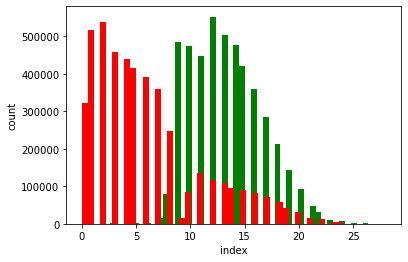

In [14]:
f=plt.hist(x=scc['atom_index_0'],bins=50,color='green')
g=plt.hist(x=scc['atom_index_1'],bins=50,color='red')

plt.xlabel('index')
plt.ylabel('count')
plt.show()

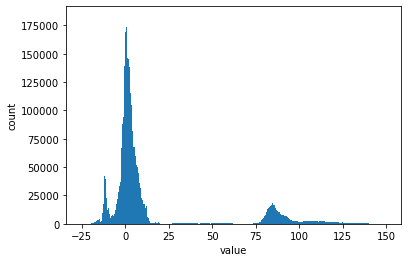

In [15]:
u=plt.hist(x=train['scalar_coupling_constant'],bins=500,range=(-25,150))

plt.xlabel('value')
plt.ylabel('count')
plt.show()

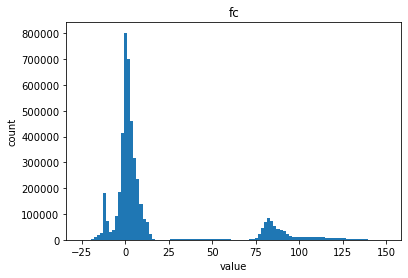

In [16]:
h=plt.hist(x=scc['fc'],bins=100,range=(-25,150))
plt.title('fc')
plt.xlabel('value')
plt.ylabel('count')
plt.show()

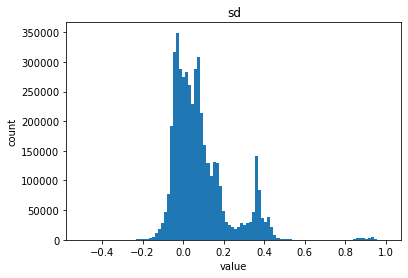

In [17]:
j=plt.hist(x=scc['sd'],bins=100,range=(-0.5,1))
plt.title('sd')
plt.xlabel('value')
plt.ylabel('count')
plt.show()

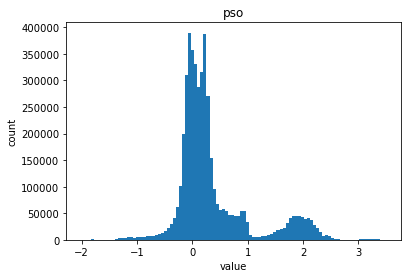

In [18]:
k=plt.hist(x=scc['pso'],bins=100,range=(-2,3.5))
plt.title('pso')
plt.xlabel('value')
plt.ylabel('count')
plt.show()

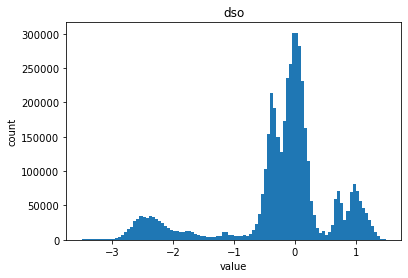

In [19]:
j=plt.hist(x=scc['dso'],bins=100,range=(-3.5,1.5))
plt.title('dso')
plt.xlabel('value')
plt.ylabel('count')
plt.show()

In [20]:
random_molecule = random.choice(structures['molecule_name'].unique())
molecule = structures[structures['molecule_name'] == random_molecule]
display(molecule)

molecule_name  atom_index atom         x         y         z
565849  dsgdb9nsd_035890           0    N -0.284844 -1.180844 -0.253133
565850  dsgdb9nsd_035890           1    C -0.135923 -0.046077 -0.093024
565851  dsgdb9nsd_035890           2    C -0.004272  1.384912  0.143172
565852  dsgdb9nsd_035890           3    C -0.551829  1.822586  1.550525
565853  dsgdb9nsd_035890           4    N  0.245030  2.967889  1.965239
565854  dsgdb9nsd_035890           5    C  1.599044  2.654456  1.532635
565855  dsgdb9nsd_035890           6    C  1.468474  1.952996  0.131431
565856  dsgdb9nsd_035890           7    C  2.523685  0.979226 -0.111843
565857  dsgdb9nsd_035890           8    N  3.393828  0.237129 -0.278121
565858  dsgdb9nsd_035890           9    H -0.570341  1.899331 -0.638790
565859  dsgdb9nsd_035890          10    H -1.616356  2.059482  1.521464
565860  dsgdb9nsd_035890          11    H -0.404076  1.002195  2.260407
565861  dsgdb9nsd_035890          12    H -0.084299  3.809321  1.501287
565862  dsgdb9nsd_035890          13    H  2.226333  3.545946  1.488674
565863  dsgdb9nsd_035890          14    H  2.052331  1.952890  2.240534
565864  dsgdb9nsd_035890          15    H  1.532261  2.708783 -0.656741

In [21]:
atoms = molecule.iloc[:, 3:].values
print(atoms)

[[-0.28484424 -1.18084414 -0.25313255]
 [-0.13592315 -0.04607669 -0.09302369]
 [-0.00427239  1.38491224  0.14317165]
 [-0.55182939  1.82258606  1.550525  ]
 [ 0.24503033  2.96788898  1.96523878]
 [ 1.59904443  2.65445581  1.53263469]
 [ 1.46847404  1.95299622  0.13143072]
 [ 2.52368465  0.97922582 -0.11184334]
 [ 3.39382839  0.23712868 -0.27812123]
 [-0.57034147  1.89933121 -0.6387897 ]
 [-1.61635614  2.05948162  1.52146413]
 [-0.40407645  1.00219475  2.26040661]
 [-0.08429912  3.80932063  1.50128705]
 [ 2.22633335  3.54594593  1.48867411]
 [ 2.05233134  1.95288972  2.24053386]
 [ 1.53226137  2.70878333 -0.65674121]]


In [22]:
symbols = molecule.iloc[:, 2].values
print(symbols)

['N' 'C' 'C' 'C' 'N' 'C' 'C' 'C' 'N' 'H' 'H' 'H' 'H' 'H' 'H' 'H']


In [23]:
system = Atoms(positions=atoms, symbols=symbols)

ase.visualize.view(system, viewer="x3d")

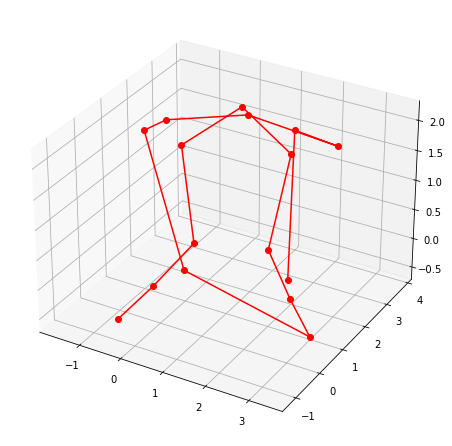

In [24]:
fig = plt.figure()
x = molecule['x']
y = molecule['y']
z = molecule['z']
ax = fig.add_axes((1,10,1,15), projection='3d')
ax.plot(x, y, z, c='red', marker='o')
plt.show()

In [25]:
atomic_radius = {'H':0.38, 'C':0.77, 'N':0.75, 'O':0.73, 'F':0.71} # Without fudge factor

fudge_factor = 0.05
atomic_radius = {k:v + fudge_factor for k,v in atomic_radius.items()}
print(atomic_radius)

electronegativity = {'H':2.2, 'C':2.55, 'N':3.04, 'O':3.44, 'F':3.98}

#structures = pd.read_csv(structures, dtype={'atom_index':np.int8})

atoms = structures['atom'].values
atoms_en = [electronegativity[x] for x in tqdm(atoms)]
atoms_rad = [atomic_radius[x] for x in tqdm(atoms)]

structures['EN'] = atoms_en
structures['rad'] = atoms_rad

i_atom = structures['atom_index'].values
p = structures[['x', 'y', 'z']].values
p_compare = p
m = structures['molecule_name'].values
m_compare = m
r = structures['rad'].values
r_compare = r

source_row = np.arange(len(structures))
max_atoms = 28

bonds = np.zeros((len(structures)+1, max_atoms+1), dtype=np.int8)
bond_dists = np.zeros((len(structures)+1, max_atoms+1), dtype=np.float32)

print('Calculating bonds')

for i in tqdm(range(max_atoms-1)):
    p_compare = np.roll(p_compare, -1, axis=0)
    m_compare = np.roll(m_compare, -1, axis=0)
    r_compare = np.roll(r_compare, -1, axis=0)
    
    mask = np.where(m == m_compare, 1, 0) #Are we still comparing atoms in the same molecule?
    dists = np.linalg.norm(p - p_compare, axis=1) * mask
    r_bond = r + r_compare
    
    bond = np.where(np.logical_and(dists > 0.0001, dists < r_bond), 1, 0)
    
    source_row = source_row
    target_row = source_row + i + 1 #Note: Will be out of bounds of bonds array for some values of i
    target_row = np.where(np.logical_or(target_row > len(structures), mask==0), len(structures), target_row) #If invalid target, write to dummy row
    
    source_atom = i_atom
    target_atom = i_atom + i + 1 #Note: Will be out of bounds of bonds array for some values of i
    target_atom = np.where(np.logical_or(target_atom > max_atoms, mask==0), max_atoms, target_atom) #If invalid target, write to dummy col
    
    bonds[(source_row, target_atom)] = bond
    bonds[(target_row, source_atom)] = bond
    bond_dists[(source_row, target_atom)] = dists
    bond_dists[(target_row, source_atom)] = dists

bonds = np.delete(bonds, axis=0, obj=-1) #Delete dummy row
bonds = np.delete(bonds, axis=1, obj=-1) #Delete dummy col
bond_dists = np.delete(bond_dists, axis=0, obj=-1) #Delete dummy row
bond_dists = np.delete(bond_dists, axis=1, obj=-1) #Delete dummy col

print('Counting and condensing bonds')

bonds_numeric = [[i for i,x in enumerate(row) if x] for row in tqdm(bonds)]
bond_lengths = [[dist for i,dist in enumerate(row) if i in bonds_numeric[j]] for j,row in enumerate(tqdm(bond_dists))]
bond_lengths_mean = [ np.mean(x) for x in bond_lengths]
n_bonds = [len(x) for x in bonds_numeric]

#bond_data = {'bond_' + str(i):col for i, col in enumerate(np.transpose(bonds))}
#bond_data.update({'bonds_numeric':bonds_numeric, 'n_bonds':n_bonds})

bond_data = {'n_bonds':n_bonds, 'bond_lengths_mean': bond_lengths_mean }
bond_df = pd.DataFrame(bond_data)
structures = structures.join(bond_df)
display(structures.head(20))

{'H': 0.43, 'C': 0.8200000000000001, 'N': 0.8, 'O': 0.78, 'F': 0.76}


<ipython-input-25-6de3769a9b55>:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  atoms_en = [electronegativity[x] for x in tqdm(atoms)]


  0%|          | 0/2358875 [00:00<?, ?it/s]

<ipython-input-25-6de3769a9b55>:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  atoms_rad = [atomic_radius[x] for x in tqdm(atoms)]


  0%|          | 0/2358875 [00:00<?, ?it/s]

Calculating bonds


<ipython-input-25-6de3769a9b55>:34: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(max_atoms-1)):


  0%|          | 0/27 [00:00<?, ?it/s]

Counting and condensing bonds


<ipython-input-25-6de3769a9b55>:65: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  bonds_numeric = [[i for i,x in enumerate(row) if x] for row in tqdm(bonds)]


  0%|          | 0/2358875 [00:00<?, ?it/s]

<ipython-input-25-6de3769a9b55>:66: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  bond_lengths = [[dist for i,dist in enumerate(row) if i in bonds_numeric[j]] for j,row in enumerate(tqdm(bond_dists))]


  0%|          | 0/2358875 [00:00<?, ?it/s]

molecule_name  atom_index atom         x         y         z    EN  \
0   dsgdb9nsd_000001           0    C -0.012698  1.085804  0.008001  2.55   
1   dsgdb9nsd_000001           1    H  0.002150 -0.006031  0.001976  2.20   
2   dsgdb9nsd_000001           2    H  1.011731  1.463751  0.000277  2.20   
3   dsgdb9nsd_000001           3    H -0.540815  1.447527 -0.876644  2.20   
4   dsgdb9nsd_000001           4    H -0.523814  1.437933  0.906397  2.20   
5   dsgdb9nsd_000002           0    N -0.040426  1.024108  0.062564  3.04   
6   dsgdb9nsd_000002           1    H  0.017257  0.012545 -0.027377  2.20   
7   dsgdb9nsd_000002           2    H  0.915789  1.358745 -0.028758  2.20   
8   dsgdb9nsd_000002           3    H -0.520278  1.343532 -0.775543  2.20   
9   dsgdb9nsd_000003           0    O -0.034360  0.977540  0.007602  3.44   
10  dsgdb9nsd_000003           1    H  0.064766  0.020572  0.001535  2.20   
11  dsgdb9nsd_000003           2    H  0.871790  1.300792  0.000693  2.20   
12  dsgdb9nsd_000004           0    C  0.599539  0.000000  1.000000  2.55   
13  dsgdb9nsd_000004           1    C -0.599539  0.000000  1.000000  2.55   
14  dsgdb9nsd_000004           2    H -1.661639  0.000000  1.000000  2.20   
15  dsgdb9nsd_000004           3    H  1.661639  0.000000  1.000000  2.20   
16  dsgdb9nsd_000005           0    C -0.013324  1.132466  0.008276  2.55   
17  dsgdb9nsd_000005           1    N  0.002311 -0.019159  0.001929  3.04   
18  dsgdb9nsd_000005           2    H -0.027803  2.198949  0.014154  2.20   
19  dsgdb9nsd_000006           0    C -0.013978  1.180211  0.007752  2.55   

     rad  n_bonds  bond_lengths_mean  
0   0.82        4           1.091950  
1   0.43        1           1.091953  
2   0.43        1           1.091952  
3   0.43        1           1.091946  
4   0.43        1           1.091948  
5   0.80        3           1.017195  
6   0.43        1           1.017190  
7   0.43        1           1.017187  
8   0.43        1           1.017208  
9   0.78        2           0.962107  
10  0.43        1           0.962107  
11  0.43        1           0.962107  
12  0.82        2           1.130589  
13  0.82        2           1.130589  
14  0.43        1           1.062099  
15  0.43        1           1.062099  
16  0.82        2           1.109173  
17  0.80        1           1.151748  
18  0.43        1           1.066598  
19  0.82        3           1.140627

In [26]:
def map_atom_info(df, atom_idx):
    df = pd.merge(df, structures, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}','x': f'x_{atom_idx}','y': f'y_{atom_idx}','z': f'z_{atom_idx}','EN':f'EN_{atom_idx}' , 'rad':f'rad_{atom_idx}' , 'n_bonds':f'n_bonds_{atom_idx}' , 'bond_lengths_mean':f'bond_lengths_mean_{atom_idx}'})
    return df


train = map_atom_info(train, 0)
train = map_atom_info(train, 1)

#test = map_atom_info(test, 0)
#test = map_atom_info(test, 1)

train_p_0 = train[['x_0', 'y_0', 'z_0']].values
train_p_1 = train[['x_1', 'y_1', 'z_1']].values
#test_p_0 = test[['x_0', 'y_0', 'z_0']].values
#test_p_1 = test[['x_1', 'y_1', 'z_1']].values

train['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
#test['dist'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)

train.head()

id     molecule_name  atom_index_0  atom_index_1  type  \
0   0  dsgdb9nsd_000001             1             0  1JHC   
1   1  dsgdb9nsd_000001             1             2  2JHH   
2   2  dsgdb9nsd_000001             1             3  2JHH   
3   3  dsgdb9nsd_000001             1             4  2JHH   
4   4  dsgdb9nsd_000001             2             0  1JHC   

   scalar_coupling_constant atom_0       x_0       y_0       z_0  ...  \
0                   84.8076      H  0.002150 -0.006031  0.001976  ...   
1                  -11.2570      H  0.002150 -0.006031  0.001976  ...   
2                  -11.2548      H  0.002150 -0.006031  0.001976  ...   
3                  -11.2543      H  0.002150 -0.006031  0.001976  ...   
4                   84.8074      H  1.011731  1.463751  0.000277  ...   

   bond_lengths_mean_0  atom_1       x_1       y_1       z_1  EN_1  rad_1  \
0             1.091953       C -0.012698  1.085804  0.008001  2.55   0.82   
1             1.091953       H  1.011731  1.463751  0.000277  2.20   0.43   
2             1.091953       H -0.540815  1.447527 -0.876644  2.20   0.43   
3             1.091953       H -0.523814  1.437933  0.906397  2.20   0.43   
4             1.091952       C -0.012698  1.085804  0.008001  2.55   0.82   

   n_bonds_1  bond_lengths_mean_1      dist  
0          4             1.091950  1.091953  
1          1             1.091952  1.783120  
2          1             1.091946  1.783147  
3          1             1.091948  1.783157  
4          4             1.091950  1.091952  

[5 rows x 23 columns]

In [27]:
train['dist_x'] = (train['x_0'] - train['x_1']) ** 2
#test['dist_x'] = (test['x_0'] - test['x_1']) ** 2
train['dist_y'] = (train['y_0'] - train['y_1']) ** 2
#test['dist_y'] = (test['y_0'] - test['y_1']) ** 2
train['dist_z'] = (train['z_0'] - train['z_1']) ** 2
#test['dist_z'] = (test['z_0'] - test['z_1']) ** 2

train['type_0'] = train['type'].apply(lambda x: x[0])
#test['type_0'] = test['type'].apply(lambda x: x[0])
train.head()

id     molecule_name  atom_index_0  atom_index_1  type  \
0   0  dsgdb9nsd_000001             1             0  1JHC   
1   1  dsgdb9nsd_000001             1             2  2JHH   
2   2  dsgdb9nsd_000001             1             3  2JHH   
3   3  dsgdb9nsd_000001             1             4  2JHH   
4   4  dsgdb9nsd_000001             2             0  1JHC   

   scalar_coupling_constant atom_0       x_0       y_0       z_0  ...  \
0                   84.8076      H  0.002150 -0.006031  0.001976  ...   
1                  -11.2570      H  0.002150 -0.006031  0.001976  ...   
2                  -11.2548      H  0.002150 -0.006031  0.001976  ...   
3                  -11.2543      H  0.002150 -0.006031  0.001976  ...   
4                   84.8074      H  1.011731  1.463751  0.000277  ...   

        z_1  EN_1  rad_1  n_bonds_1 bond_lengths_mean_1      dist    dist_x  \
0  0.008001  2.55   0.82          4            1.091950  1.091953  0.000220   
1  0.000277  2.20   0.43          1            1.091952  1.783120  1.019253   
2 -0.876644  2.20   0.43          1            1.091946  1.783147  0.294812   
3  0.906397  2.20   0.43          1            1.091948  1.783157  0.276638   
4  0.008001  2.55   0.82          4            1.091950  1.091952  1.049455   

     dist_y    dist_z  type_0  
0  1.192105  0.000036       1  
1  2.160261  0.000003       2  
2  2.112831  0.771973       2  
3  2.085032  0.817978       2  
4  0.142844  0.000060       1  

[5 rows x 27 columns]

In [28]:
train = pd.merge(train, scc, how = 'left',
                left_on  = ['molecule_name', 'atom_index_0', 'atom_index_1', 'type'],
                right_on = ['molecule_name', 'atom_index_0', 'atom_index_1', 'type'])

pd.set_option('display.max_columns',None)
train.head()

id     molecule_name  atom_index_0  atom_index_1  type  \
0   0  dsgdb9nsd_000001             1             0  1JHC   
1   1  dsgdb9nsd_000001             1             2  2JHH   
2   2  dsgdb9nsd_000001             1             3  2JHH   
3   3  dsgdb9nsd_000001             1             4  2JHH   
4   4  dsgdb9nsd_000001             2             0  1JHC   

   scalar_coupling_constant atom_0       x_0       y_0       z_0  EN_0  rad_0  \
0                   84.8076      H  0.002150 -0.006031  0.001976   2.2   0.43   
1                  -11.2570      H  0.002150 -0.006031  0.001976   2.2   0.43   
2                  -11.2548      H  0.002150 -0.006031  0.001976   2.2   0.43   
3                  -11.2543      H  0.002150 -0.006031  0.001976   2.2   0.43   
4                   84.8074      H  1.011731  1.463751  0.000277   2.2   0.43   

   n_bonds_0  bond_lengths_mean_0 atom_1       x_1       y_1       z_1  EN_1  \
0          1             1.091953      C -0.012698  1.085804  0.008001  2.55   
1          1             1.091953      H  1.011731  1.463751  0.000277  2.20   
2          1             1.091953      H -0.540815  1.447527 -0.876644  2.20   
3          1             1.091953      H -0.523814  1.437933  0.906397  2.20   
4          1             1.091952      C -0.012698  1.085804  0.008001  2.55   

   rad_1  n_bonds_1  bond_lengths_mean_1      dist    dist_x    dist_y  \
0   0.82          4             1.091950  1.091953  0.000220  1.192105   
1   0.43          1             1.091952  1.783120  1.019253  2.160261   
2   0.43          1             1.091946  1.783147  0.294812  2.112831   
3   0.43          1             1.091948  1.783157  0.276638  2.085032   
4   0.82          4             1.091950  1.091952  1.049455  0.142844   

     dist_z type_0       fc        sd      pso       dso  
0  0.000036      1  83.0224  0.254579  1.25862  0.272010  
1  0.000003      2 -11.0347  0.352978  2.85839 -3.433600  
2  0.771973      2 -11.0325  0.352944  2.85852 -3.433870  
3  0.817978      2 -11.0319  0.352934  2.85855 -3.433930  
4  0.000060      1  83.0222  0.254585  1.25861  0.272013

In [29]:
train,test = train_test_split(train ,test_size=0.9, train_size=0.1,random_state=23,shuffle=False)

train,test = train_test_split(train ,test_size=0.2, train_size=0.8,random_state=12,shuffle=False)

In [30]:
train

id     molecule_name  atom_index_0  atom_index_1  type  \
0            0  dsgdb9nsd_000001             1             0  1JHC   
1            1  dsgdb9nsd_000001             1             2  2JHH   
2            2  dsgdb9nsd_000001             1             3  2JHH   
3            3  dsgdb9nsd_000001             1             4  2JHH   
4            4  dsgdb9nsd_000001             2             0  1JHC   
...        ...               ...           ...           ...   ...   
372720  372720  dsgdb9nsd_012649            11             6  2JHC   
372721  372721  dsgdb9nsd_012649            11            12  3JHH   
372722  372722  dsgdb9nsd_012649            11            13  3JHH   
372723  372723  dsgdb9nsd_012649            12             0  3JHC   
372724  372724  dsgdb9nsd_012649            12             1  2JHC   

        scalar_coupling_constant atom_0       x_0       y_0       z_0  EN_0  \
0                      84.807600      H  0.002150 -0.006031  0.001976   2.2   
1                     -11.257000      H  0.002150 -0.006031  0.001976   2.2   
2                     -11.254800      H  0.002150 -0.006031  0.001976   2.2   
3                     -11.254300      H  0.002150 -0.006031  0.001976   2.2   
4                      84.807400      H  1.011731  1.463751  0.000277   2.2   
...                          ...    ...       ...       ...       ...   ...   
372720                 -4.653470      H -0.784442 -0.559397  0.029365   2.2   
372721                  7.386430      H -0.784442 -0.559397  0.029365   2.2   
372722                  5.922370      H -0.784442 -0.559397  0.029365   2.2   
372723                  0.404478      H  0.346718 -0.766358 -2.048609   2.2   
372724                 -1.815360      H  0.346718 -0.766358 -2.048609   2.2   

        rad_0  n_bonds_0  bond_lengths_mean_0 atom_1       x_1       y_1  \
0        0.43          1             1.091953      C -0.012698  1.085804   
1        0.43          1             1.091953      H  1.011731  1.463751   
2        0.43          1             1.091953      H -0.540815  1.447527   
3        0.43          1             1.091953      H -0.523814  1.437933   
4        0.43          1             1.091952      C -0.012698  1.085804   
...       ...        ...                  ...    ...       ...       ...   
372720   0.43          1             1.099647      C  0.961353 -0.370526   
372721   0.43          1             1.099647      H  0.346718 -0.766358   
372722   0.43          1             1.099647      H  1.574366  0.431276   
372723   0.43          1             1.094144      C -0.274770  1.536269   
372724   0.43          1             1.094144      C  0.120595  0.063605   

             z_1  EN_1  rad_1  n_bonds_1  bond_lengths_mean_1      dist  \
0       0.008001  2.55   0.82          4             1.091950  1.091953   
1       0.000277  2.20   0.43          1             1.091952  1.783120   
2      -0.876644  2.20   0.43          1             1.091946  1.783147   
3       0.906397  2.20   0.43          1             1.091948  1.783157   
4       0.008001  2.55   0.82          4             1.091950  1.091952   
...          ...   ...    ...        ...                  ...       ...   
372720  1.188863  2.55   0.82          3             1.418790  2.104259   
372721 -2.048609  2.20   0.43          1             1.094144  2.374938   
372722 -1.600885  2.20   0.43          1             1.100196  3.033665   
372723  0.013882  2.55   0.82          4             1.201635  3.153126   
372724 -0.015360  2.55   0.82          4             1.424199  2.207729   

          dist_x    dist_y    dist_z type_0         fc        sd       pso  \
0       0.000220  1.192105  0.000036      1  83.022400  0.254579  1.258620   
1       1.019253  2.160261  0.000003      2 -11.034700  0.352978  2.858390   
2       0.294812  2.112831  0.771973      2 -11.032500  0.352944  2.858520   
3       0.276638  2.085032  0.817978      2 -11.031900  0.352934  2.858550   
4       1.049455  

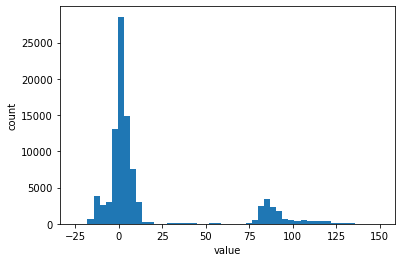

In [31]:
u=plt.hist(x=test['scalar_coupling_constant'],bins=50,range=(-25,150))

plt.xlabel('value')
plt.ylabel('count')
plt.show()

In [32]:
gc.collect()
plt.subplots(figsize=(31,31),dpi=320,facecolor='w')
sns.heatmap(train.corr(),annot=True, vmax=1,vmin=-1, square=True, cmap="RdGy_r")
plt.show()

In [33]:
train_new0 = train.drop(['molecule_name', 'type', 'atom_0', 'atom_1'], axis=1)
test_new0 = test.drop(['molecule_name', 'type', 'atom_0', 'atom_1'], axis=1)

In [34]:
bestfeatures3 = SelectKBest(f_regression, k=3)
new_3=bestfeatures3.fit_transform(train_new0.iloc[:,:],train_new0.iloc[:,3])
new_3

D:\anaconda\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:294: RuntimeWarning: invalid value encountered in sqrt
  X_norms = np.sqrt(row_norms(X.T, squared=True) -
D:\anaconda\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
D:\anaconda\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:306: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


array([[1.091953059411922, '1', 83.0224],
       [1.7831197560438021, '2', -11.0347],
       [1.7831474962399783, '2', -11.0325],
       ...,
       [3.033664930461928, '3', 6.54798],
       [3.153126377984473, '3', 0.463405],
       [2.207729428463392, '2', -1.84737]], dtype=object)

In [35]:
bestfeatures3.get_support()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False,  True,  True, False, False, False])

In [36]:
train_top3best = train.iloc[:,[22,26,27]]
test_top3best = test.iloc[:,[22,26,27]]
train_top3best.head()

dist type_0       fc
0  1.091953      1  83.0224
1  1.783120      2 -11.0347
2  1.783147      2 -11.0325
3  1.783157      2 -11.0319
4  1.091952      1  83.0222

In [37]:
bestfeatures6 = SelectKBest(f_regression, k=6)
new_6=bestfeatures6.fit_transform(train_new0.iloc[:,:],train_new0.iloc[:,3])
new_6

D:\anaconda\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:294: RuntimeWarning: invalid value encountered in sqrt
  X_norms = np.sqrt(row_norms(X.T, squared=True) -
D:\anaconda\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
D:\anaconda\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:306: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


array([[4, 1.091953059411922, '1', 83.0224, 0.254579, 0.27201],
       [1, 1.7831197560438021, '2', -11.0347, 0.352978, -3.4336],
       [1, 1.7831474962399783, '2', -11.0325, 0.352944, -3.43387],
       ...,
       [1, 3.033664930461928, '3', 6.54798, 0.025309, -2.38155],
       [4, 3.153126377984473, '3', 0.463405, -0.011733, -0.153229],
       [4, 2.207729428463392, '2', -1.84737, 0.070747,
        -0.0265149999999999]], dtype=object)

In [38]:
bestfeatures6.get_support()

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
        True, False, False, False,  True,  True,  True, False,  True])

In [39]:
train_top6best = train.iloc[:,[20,22,26,27,28,30]]
test_top6best = test.iloc[:,[20,22,26,27,28,30]]
train_top6best.head()

n_bonds_1      dist type_0       fc        sd       dso
0          4  1.091953      1  83.0224  0.254579  0.272010
1          1  1.783120      2 -11.0347  0.352978 -3.433600
2          1  1.783147      2 -11.0325  0.352944 -3.433870
3          1  1.783157      2 -11.0319  0.352934 -3.433930
4          4  1.091952      1  83.0222  0.254585  0.272013

In [40]:
bestfeatures10 = SelectKBest(f_regression, k=10)
new_10=bestfeatures10.fit_transform(train_new0.iloc[:,:],train_new0.iloc[:,3])
new_10

D:\anaconda\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:294: RuntimeWarning: invalid value encountered in sqrt
  X_norms = np.sqrt(row_norms(X.T, squared=True) -
D:\anaconda\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
D:\anaconda\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:306: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom


array([[0, 0.8200000000000001, 4, ..., 83.0224, 0.254579, 0.27201],
       [2, 0.43, 1, ..., -11.0347, 0.352978, -3.4336],
       [3, 0.43, 1, ..., -11.0325, 0.352944, -3.43387],
       ...,
       [13, 0.43, 1, ..., 6.54798, 0.025309, -2.38155],
       [0, 0.8200000000000001, 4, ..., 0.463405, -0.011733, -0.153229],
       [1, 0.8200000000000001, 4, ..., -1.84737, 0.070747,
        -0.0265149999999999]], dtype=object)

In [41]:
bestfeatures10.get_support()

array([False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True, False,
        True,  True,  True, False,  True,  True,  True, False,  True])

In [42]:
train_top10best = train.iloc[:,[3,19,20,22,23,24,26,27,28,30]]
test_top10best = test.iloc[:,[3,19,20,22,23,24,26,27,28,30]]
train_top10best.head()

atom_index_1  rad_1  n_bonds_1      dist    dist_x    dist_y type_0  \
0             0   0.82          4  1.091953  0.000220  1.192105      1   
1             2   0.43          1  1.783120  1.019253  2.160261      2   
2             3   0.43          1  1.783147  0.294812  2.112831      2   
3             4   0.43          1  1.783157  0.276638  2.085032      2   
4             0   0.82          4  1.091952  1.049455  0.142844      1   

        fc        sd       dso  
0  83.0224  0.254579  0.272010  
1 -11.0347  0.352978 -3.433600  
2 -11.0325  0.352944 -3.433870  
3 -11.0319  0.352934 -3.433930  
4  83.0222  0.254585  0.272013

In [43]:
binner = KBinsDiscretizer(n_bins=50,encode='onehot-dense',strategy='uniform')
outcome_train_new = binner.fit_transform(train_new0.iloc[:,3].values.reshape(-1, 1))
outcome_test_new = binner.fit_transform(test_new0.iloc[:,3].values.reshape(-1, 1))

In [44]:
outcome_train_new = np.matrix(outcome_train_new)
outcome_test_new = np.matrix(outcome_test_new)
train_new = train_new0.drop(['scalar_coupling_constant'],axis=1)
test_new = test_new0.drop(['scalar_coupling_constant'],axis=1)

In [45]:
max_count = -1
column = -1
for i in range(outcome_train_new.shape[1]):
    count = 0
    
    for j in range(outcome_train_new.shape[0]):
        if outcome_train_new[j,i]==1:
            count = count+1
    
    if count>max_count:
        max_count=count
        column = i

print(column, max_count)

5 116146


In [46]:
def performance(column, train_new, outcome_train_new):

    clf_Gaussian = GaussianNB()
    clf_Gaussian.fit(train_new,np.ravel(outcome_train_new[:,column]))
    result_Gaussian = cross_val_score(clf_Gaussian, train_new, np.ravel(outcome_train_new[:,column]), cv=10, scoring="accuracy")
    
    print('Gaussian naive bayes accuracy: ', result_Gaussian)
    
    out_Gaussian_pred = cross_val_predict(clf_Gaussian, train_new, np.ravel(outcome_train_new[:,column]), cv=10)
    
    print('Confusion matrix: \n', confusion_matrix(np.ravel(outcome_train_new[:,column]), out_Gaussian_pred))
    print('Precision: ', precision_score(np.ravel(outcome_train_new[:,column]), out_Gaussian_pred))
    print('Recall: ', recall_score(np.ravel(outcome_train_new[:,column]), out_Gaussian_pred))
    print('F score: ', f1_score(np.ravel(outcome_train_new[:,column]), out_Gaussian_pred))
    
    sgd_clf = SGDClassifier(max_iter=6000)
    sgd_clf.fit(train_new, np.ravel(outcome_train_new[:,column]))
    test_score = sgd_clf.decision_function(train_new)
    fpr, tpr, thresholds = roc_curve(np.ravel(outcome_train_new[:,column]), test_score)

    def plot_roc_curve(fpr, tpr, label=None):
        plt.plot(fpr, tpr, linewidth=2, label=label)
        plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
        plt.axis([0, 1, 0, 1])                                    
        plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
        plt.ylabel('True Positive Rate (Recall)', fontsize=16)  
        plt.grid(True)                                           

    plot_roc_curve(fpr, tpr)
    plt.show()

    print('AUC score: ', roc_auc_score(np.ravel(outcome_train_new[:,column]), test_score))

Gaussian naive bayes accuracy:  [0.72451909 0.70133877 0.66836584 0.66812438 0.70259974 0.68984761
 0.69615261 0.70913823 0.68818416 0.68890856]
Confusion matrix: 
 [[142995 113584]
 [   575 115571]]
Precision:  0.5043354934433025
Recall:  0.9950493344583542
F score:  0.6693927906377335


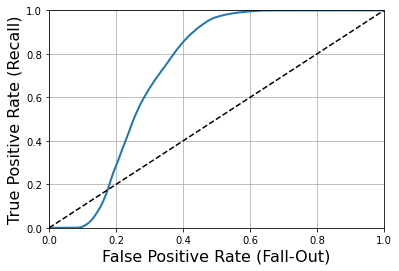

AUC score:  0.7248354576379966


In [47]:
performance(column, train_new, outcome_train_new)

Gaussian naive bayes accuracy:  [0.87376922 0.86893998 0.88112038 0.90440802 0.85260108 0.86453638
 0.86831938 0.85643378 0.87569757 0.87124383]
Confusion matrix: 
 [[208858  47721]
 [    97 116049]]
Precision:  0.7086096354643707
Recall:  0.9991648442477571
F score:  0.8291701796253161


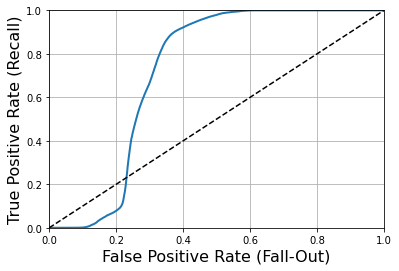

AUC score:  0.720501302565084


In [48]:
performance(column, train_top3best, outcome_train_new)

Gaussian naive bayes accuracy:  [0.83862313 0.82738175 0.83403536 0.85439863 0.81740134 0.82616978
 0.82692101 0.8227624  0.83633827 0.82555269]
Confusion matrix: 
 [[197103  59476]
 [  3530 112616]]
Precision:  0.6543941612625804
Recall:  0.9696072185008524
F score:  0.7814098071732387


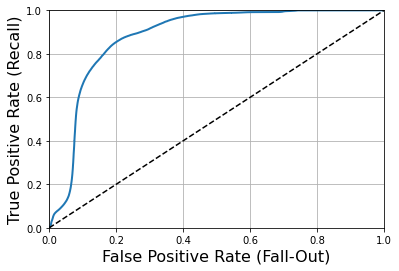

AUC score:  0.8798101534444842


In [49]:
performance(column, train_top6best, outcome_train_new)

Gaussian naive bayes accuracy:  [0.82523543 0.81809889 0.8077697  0.81852816 0.81584525 0.82297703
 0.81305001 0.83051621 0.82579416 0.81830865]
Confusion matrix: 
 [[199296  57283]
 [  9952 106194]]
Precision:  0.6495959676284737
Recall:  0.9143147417905051
F score:  0.7595512529369902


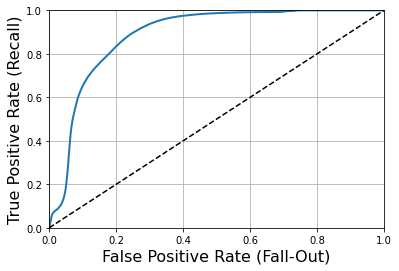

AUC score:  0.886081123094358


In [50]:
performance(column, train_top10best, outcome_train_new)

In [51]:
train_top2best = train_top3best.drop(['type_0'],axis = 1)

In [52]:
from sklearn.cluster import KMeans
k = 5
kmeans = KMeans(n_clusters=k, random_state=27)
y_pred = kmeans.fit_predict(train_top2best)
y_pred

array([1, 3, 3, ..., 0, 0, 0])

In [53]:
kmeans.cluster_centers_

array([[  2.70045609,   3.36709184],
       [  1.0907318 ,  83.1216162 ],
       [  1.08791552, 115.90473597],
       [  1.91474101,  -8.79371199],
       [  1.06219807, 196.23213171]])

In [54]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

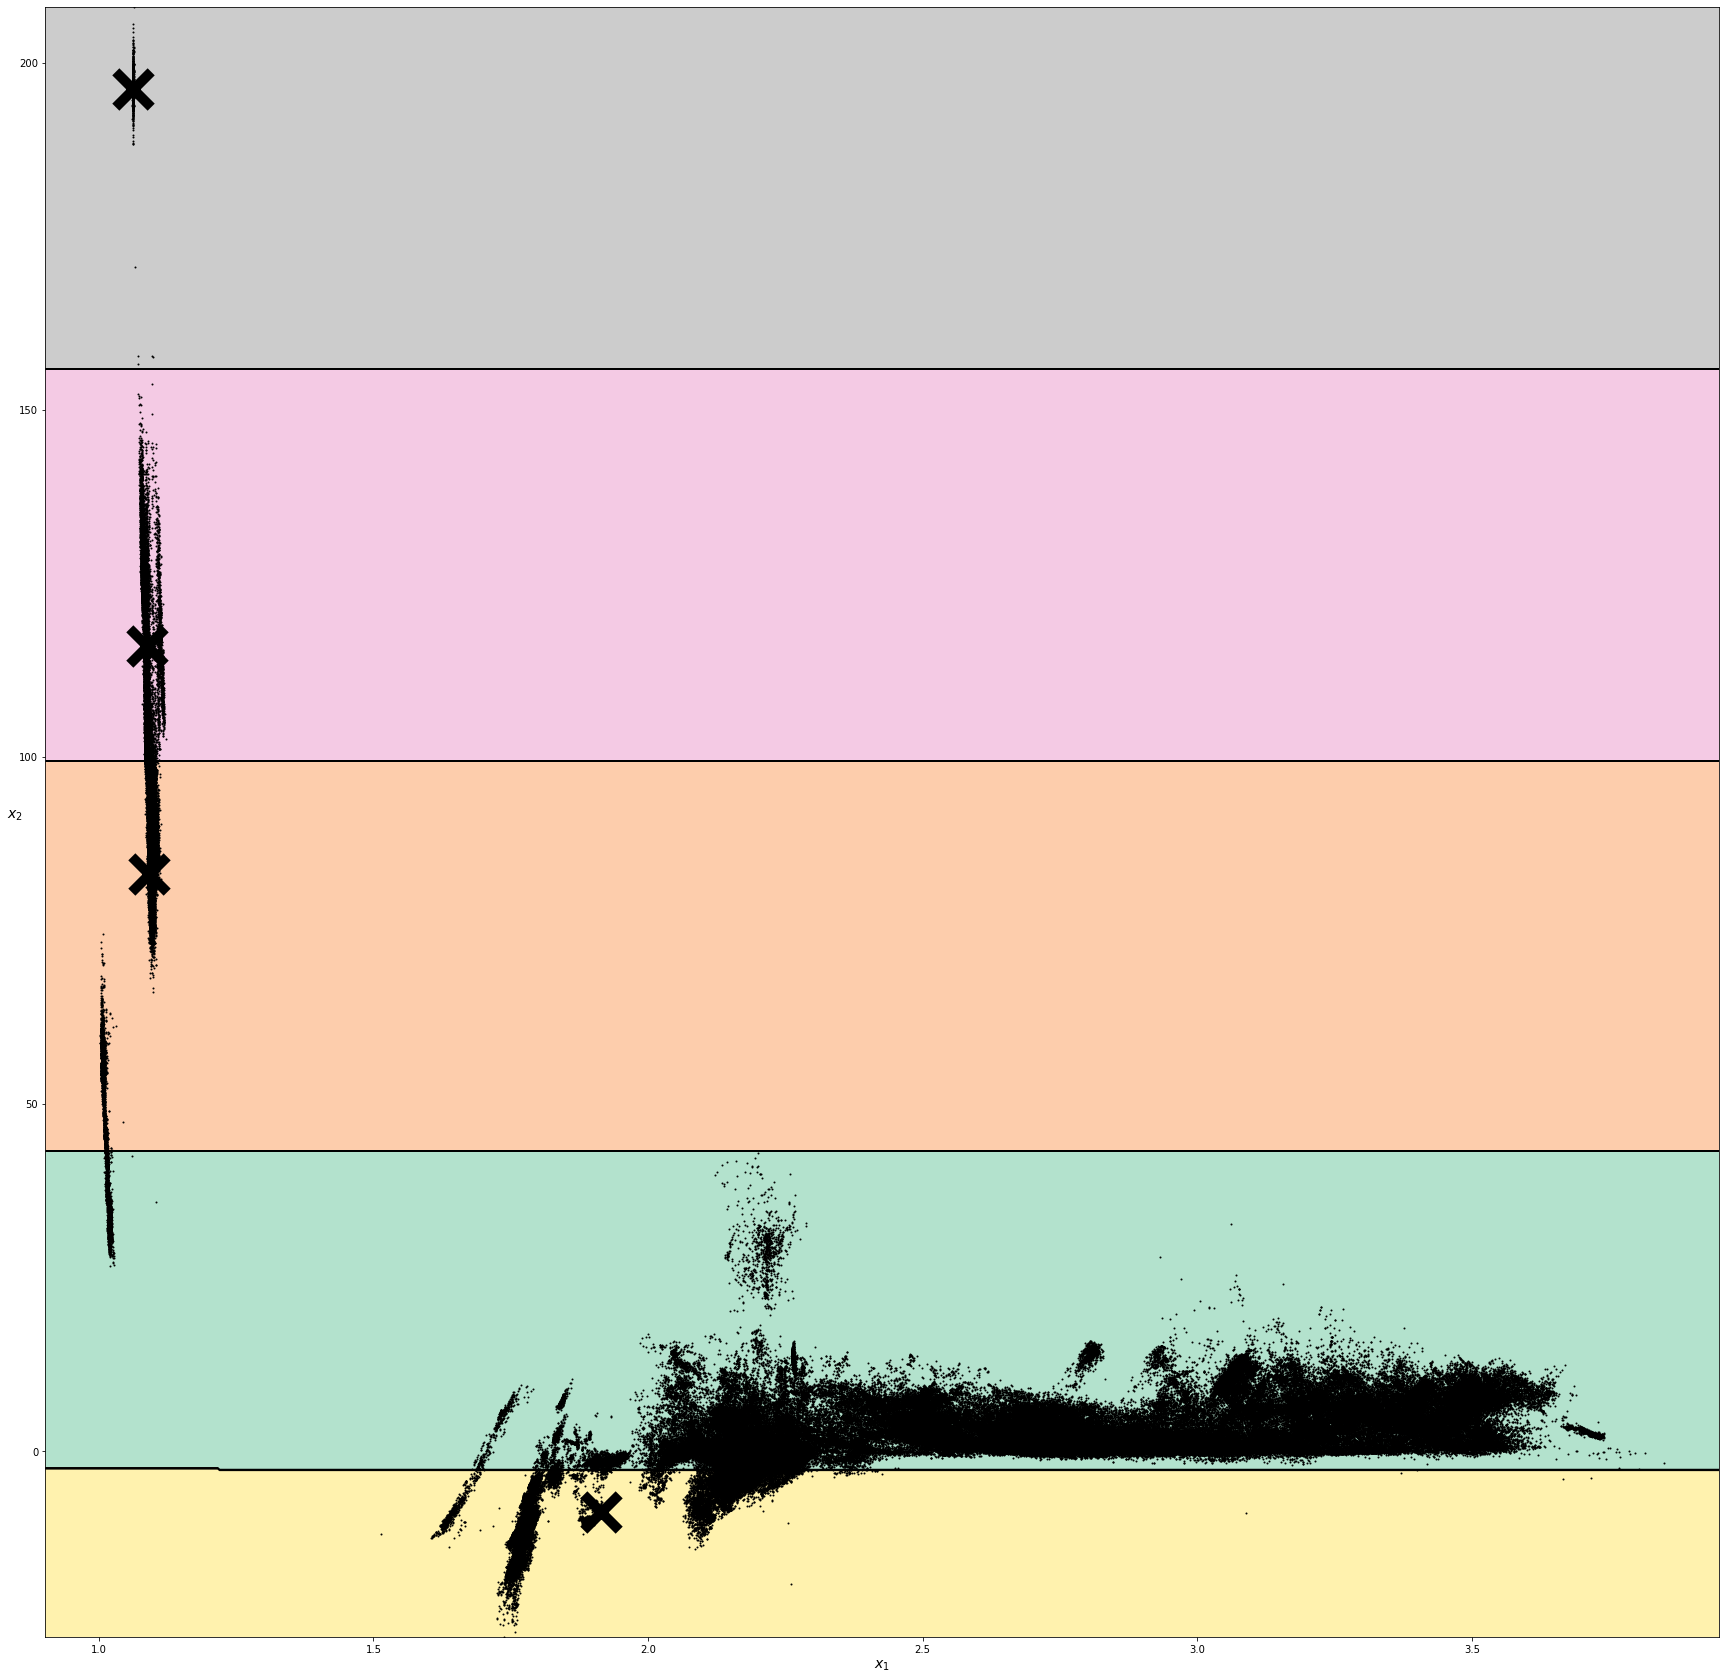

In [55]:
plt.figure(figsize=(30, 30))
plot_decision_boundaries(kmeans, np.array(train_top2best))
plt.show()

In [56]:
kmeans.transform(train_top2best)

array([[7.96715470e+01, 9.92237191e-02, 3.28823362e+01, 9.18197985e+01,
        1.13209736e+02],
       [1.44309776e+01, 9.41588619e+01, 1.26941340e+02, 2.24484997e+00,
        2.07268085e+02],
       [1.44287803e+01, 9.41566622e+01, 1.26939140e+02, 2.24265213e+00,
        2.07265886e+02],
       ...,
       [3.19829292e+00, 7.65982816e+01, 1.09374065e+02, 1.53824414e+01,
        1.89694397e+02],
       [2.93875954e+00, 8.26839365e+01, 1.15459802e+02, 9.33958315e+00,
        1.95779893e+02],
       [5.23768955e+00, 8.49763279e+01, 1.17757431e+02, 6.95251820e+00,
        1.98082814e+02]])

In [57]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=27).fit(train_top2best)
                for k in range(1, 6)]
inertias = [model.inertia_ for model in kmeans_per_k]

In [58]:
inertias

[462195281.520507,
 40944937.41217561,
 25053839.75082864,
 18159936.141527377,
 12380098.312410941]

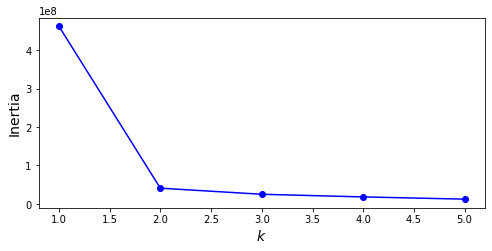

In [59]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 6), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.show()

<ipython-input-54-1d8b7897ce19>:25: UserWarning: No contour levels were found within the data range.
  plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),


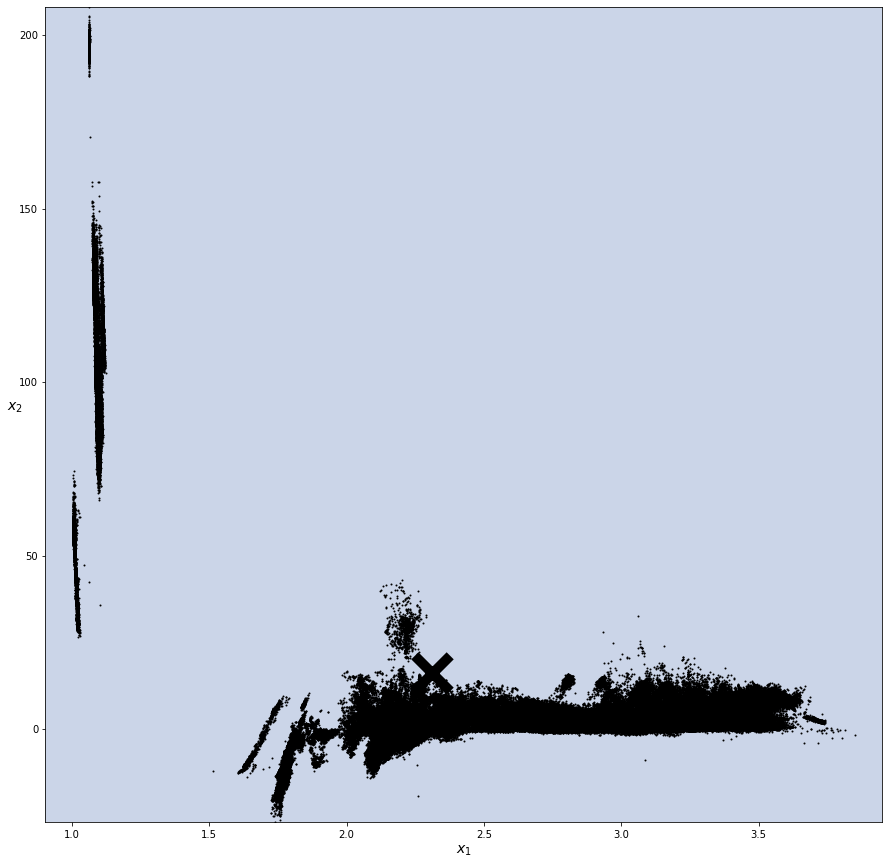

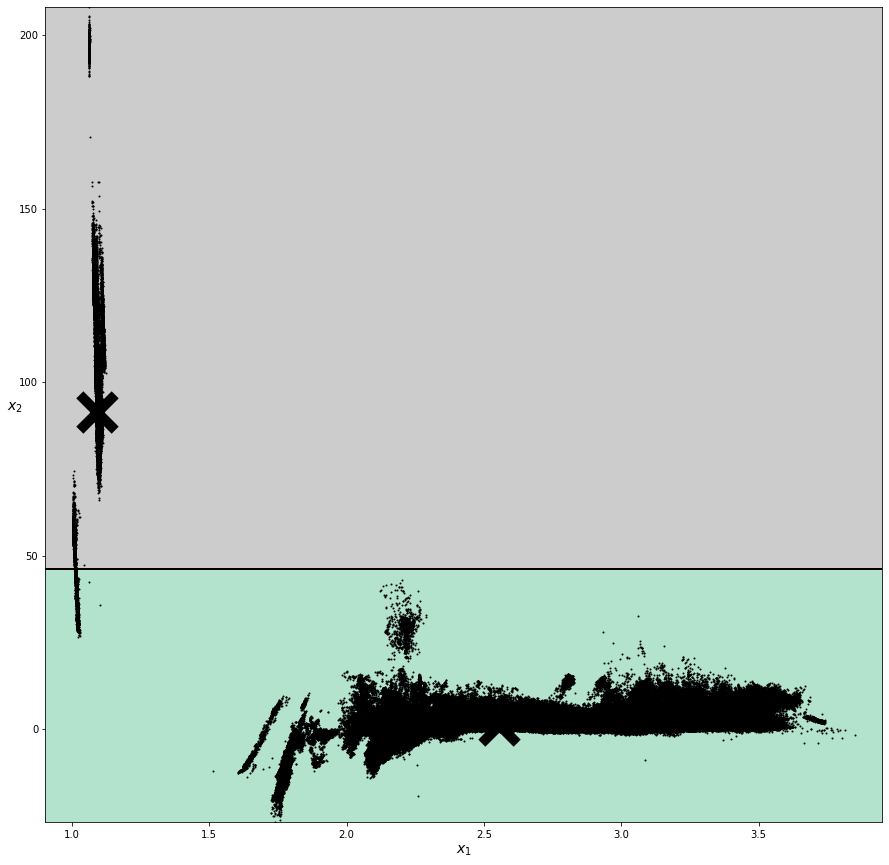

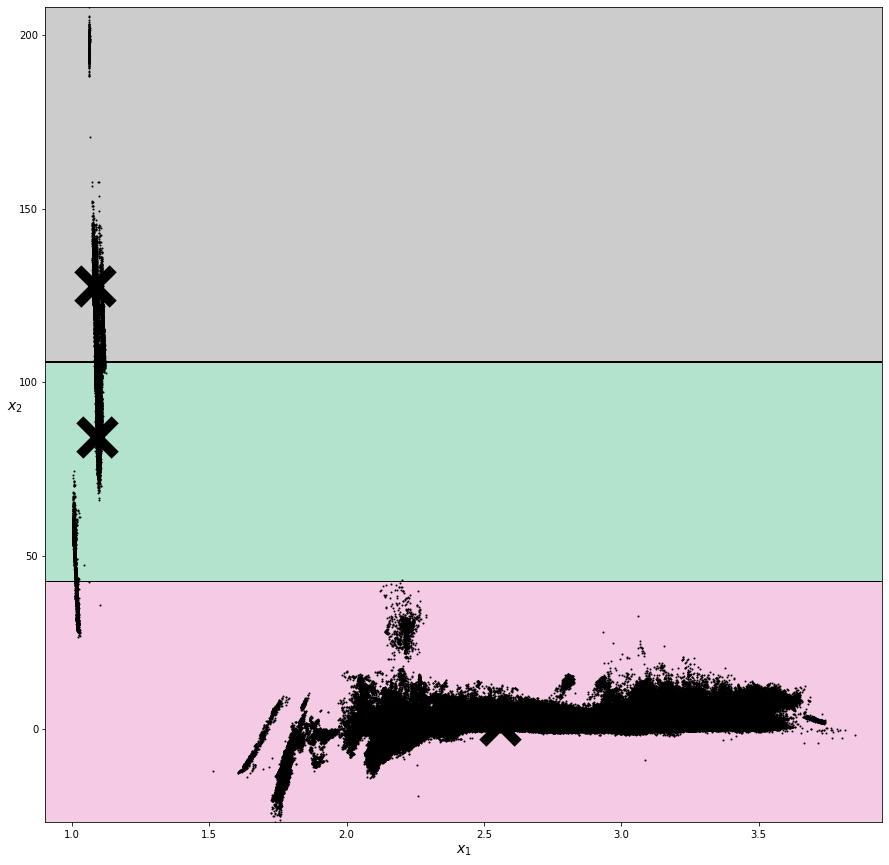

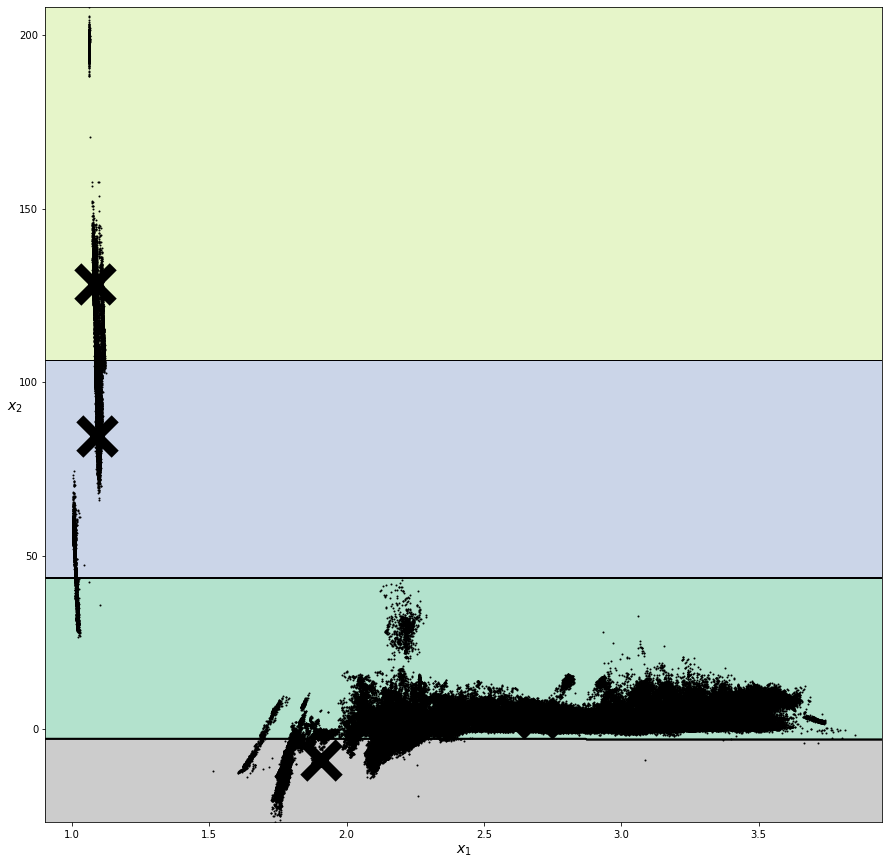

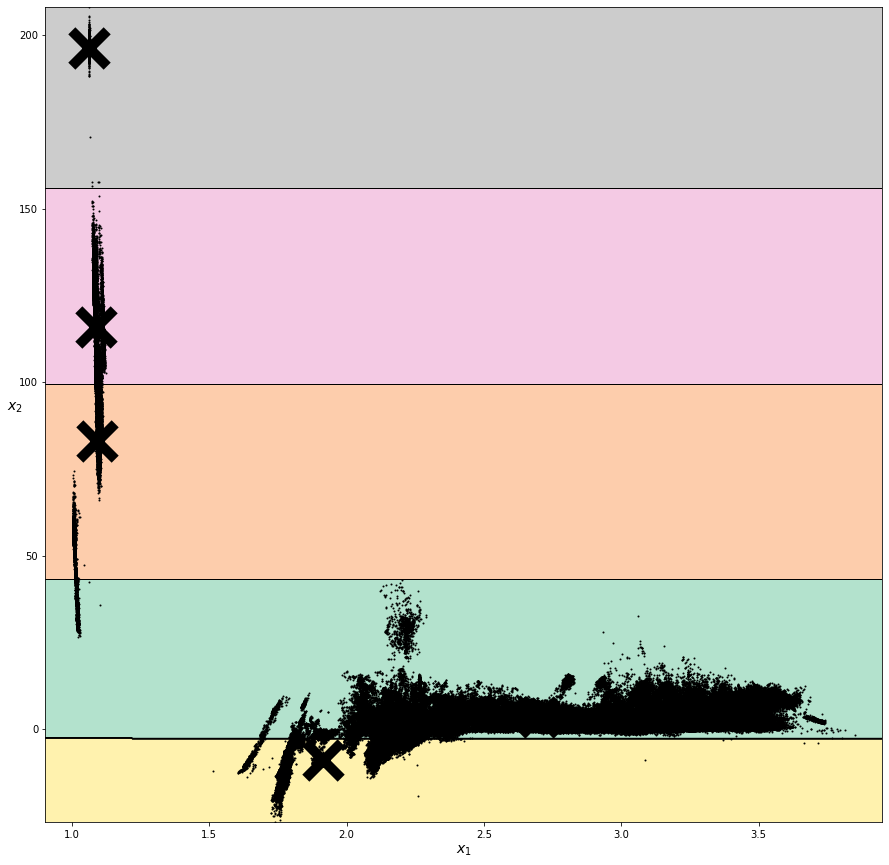

In [60]:
for model in kmeans_per_k:
    plt.figure(figsize=(15, 15))
    plot_decision_boundaries(model, np.array(train_top2best))
    plt.show()

In [61]:
# from sklearn.metrics import silhouette_score
# silhouette_scores = [silhouette_score(train_top2best, model.labels_)
#                      for model in kmeans_per_k[1:]]

In [62]:
# plt.figure(figsize=(8, 3))
# plt.plot(range(2, 6), silhouette_scores, "bo-")
# plt.xlabel("$k$", fontsize=14)
# plt.ylabel("Silhouette score", fontsize=14)
# plt.show()

In [63]:
# from sklearn.metrics import silhouette_samples
# from matplotlib.ticker import FixedLocator, FixedFormatter

# def plot_silhouette(X):
#     for k in range(1,20,1):
#     plt.subplot(2, 2, k - 2)
    
#     y_pred = kmeans_per_k[k - 1].labels_
#     silhouette_coefficients = silhouette_samples(X, y_pred)

#     padding = len(X) // 30
#     pos = padding
#     ticks = []
#     for i in range(k):
#         coeffs = silhouette_coefficients[y_pred == i]
#         coeffs.sort()

#         color = mpl.cm.Spectral(i / k)
#         plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
#                           facecolor=color, edgecolor=color, alpha=0.7)
#         ticks.append(pos + len(coeffs) // 2)
#         pos += len(coeffs) + padding

#     plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
#     plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
#     if k in (3, 5):
#         plt.ylabel("Cluster")
    
#     if k in (5, 6):
#         plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
#         plt.xlabel("Silhouette Coefficient")
#     else:
#         plt.tick_params(labelbottom=False)

#     plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
#     plt.title("$k={}$".format(k), fontsize=16)

# plot_silhouette(train_top2best)
# plt.figure(figsize=(11, 9))
# plt.show()

In [64]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=4, covariance_type='full', random_state=27).fit(train_top2best)
gm.means_

array([[ 2.05580356, -5.0236411 ],
       [ 1.08765301, 89.61402718],
       [ 2.97714295,  7.85712554],
       [ 2.7260546 ,  1.87080757]])

In [65]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

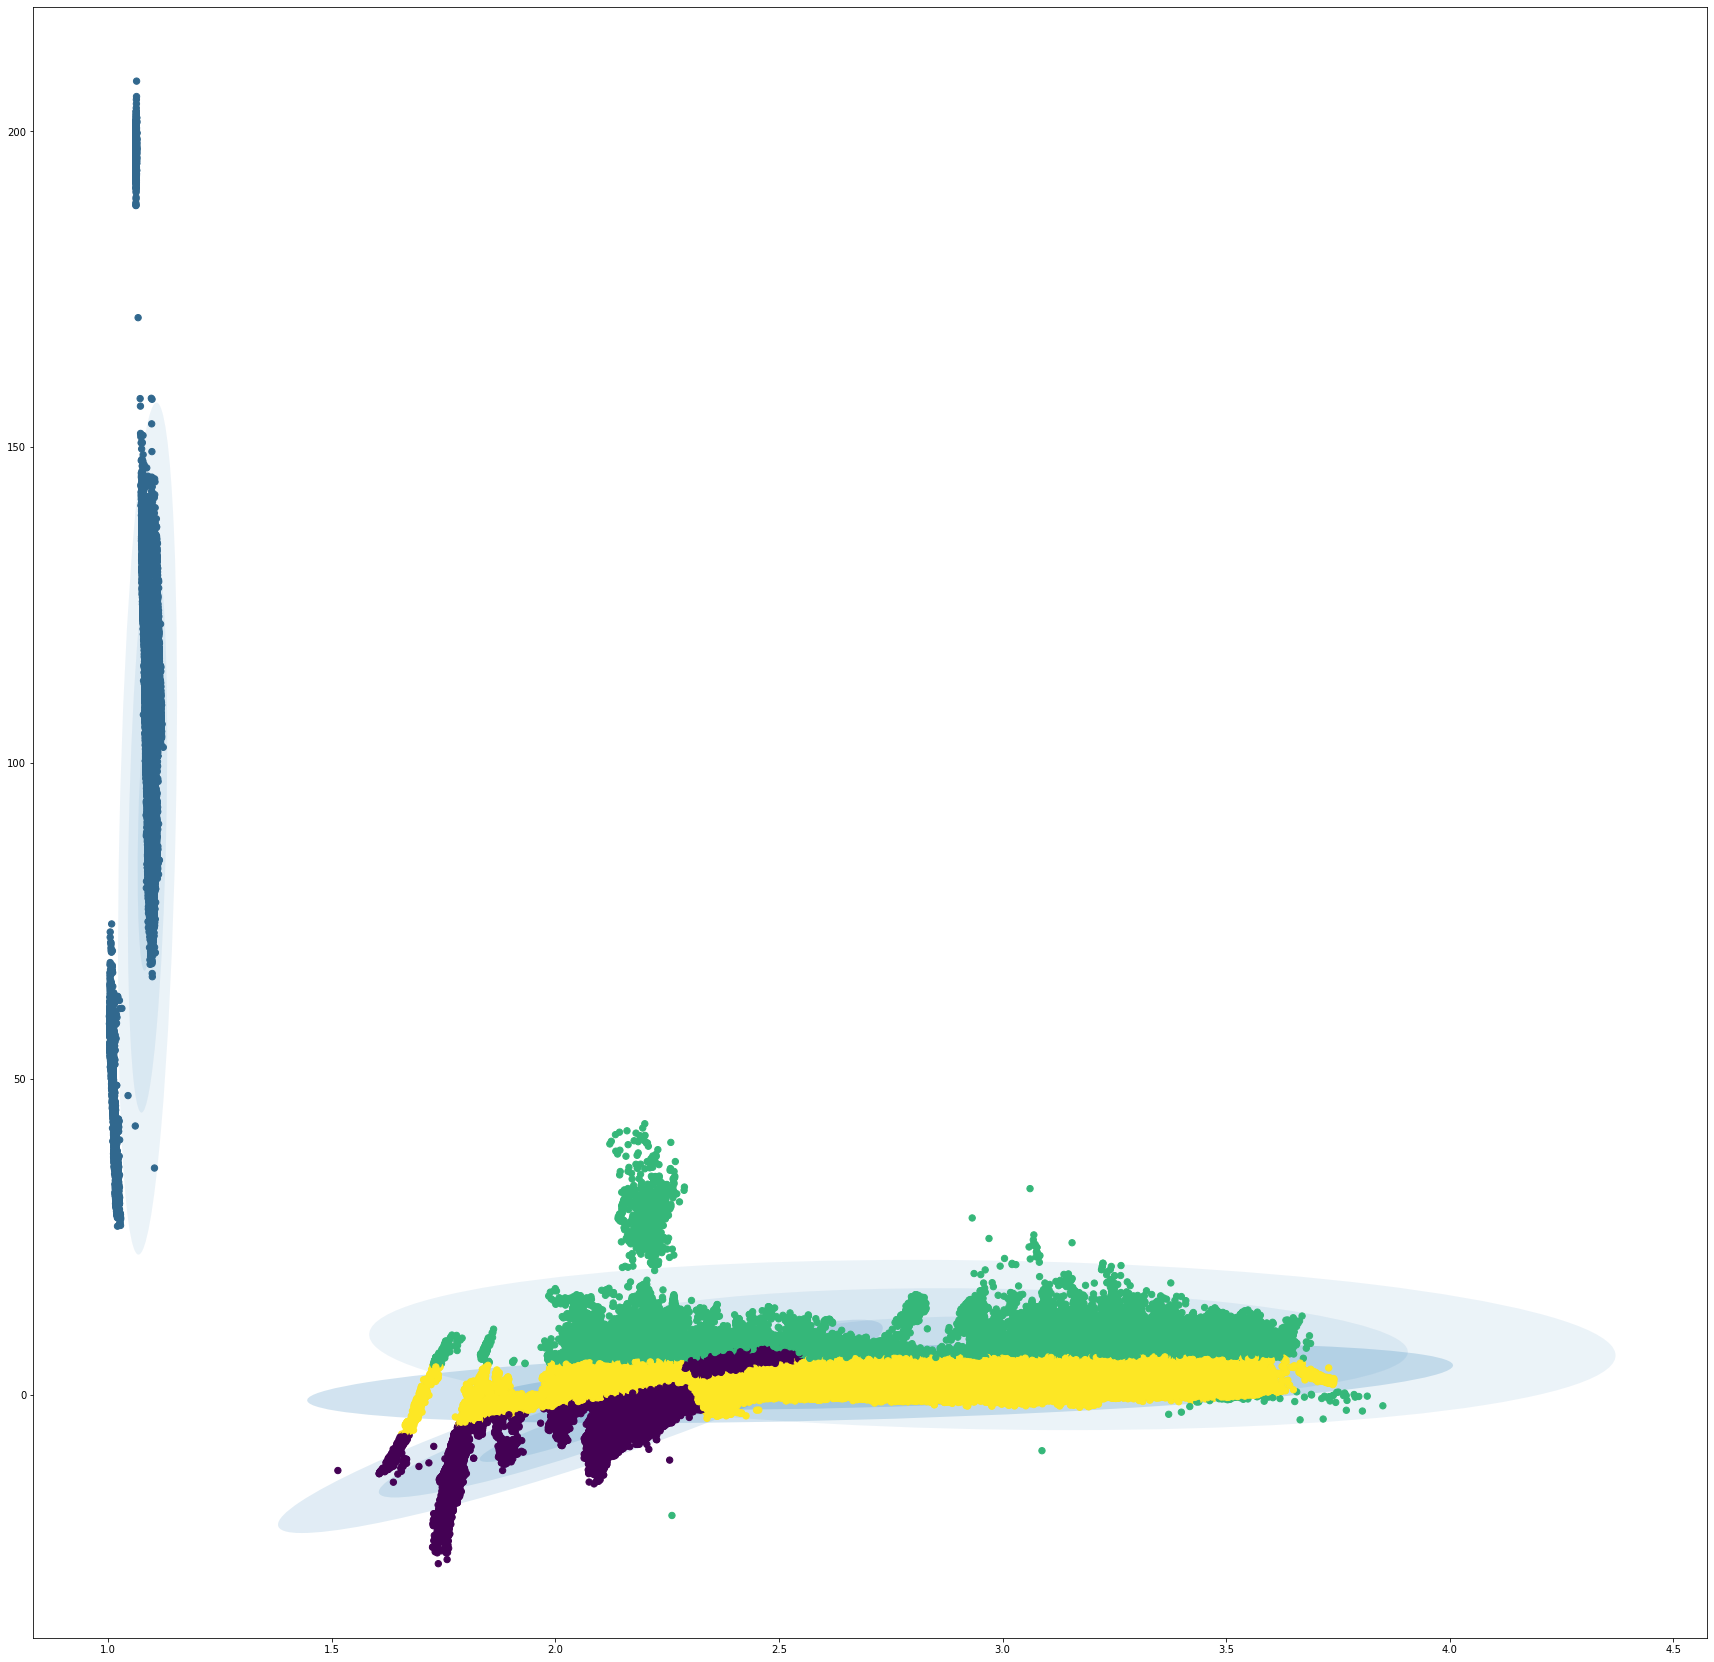

In [66]:
plt.figure(figsize=(30, 30))
plot_gmm(gm, np.array(train_top2best))
plt.show()

In [67]:
from matplotlib.colors import LogNorm

def plot_gaussian_mixture(clusterer, X, resolution=1000, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=1)
    plot_centroids(clusterer.means_, clusterer.weights_)

    plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

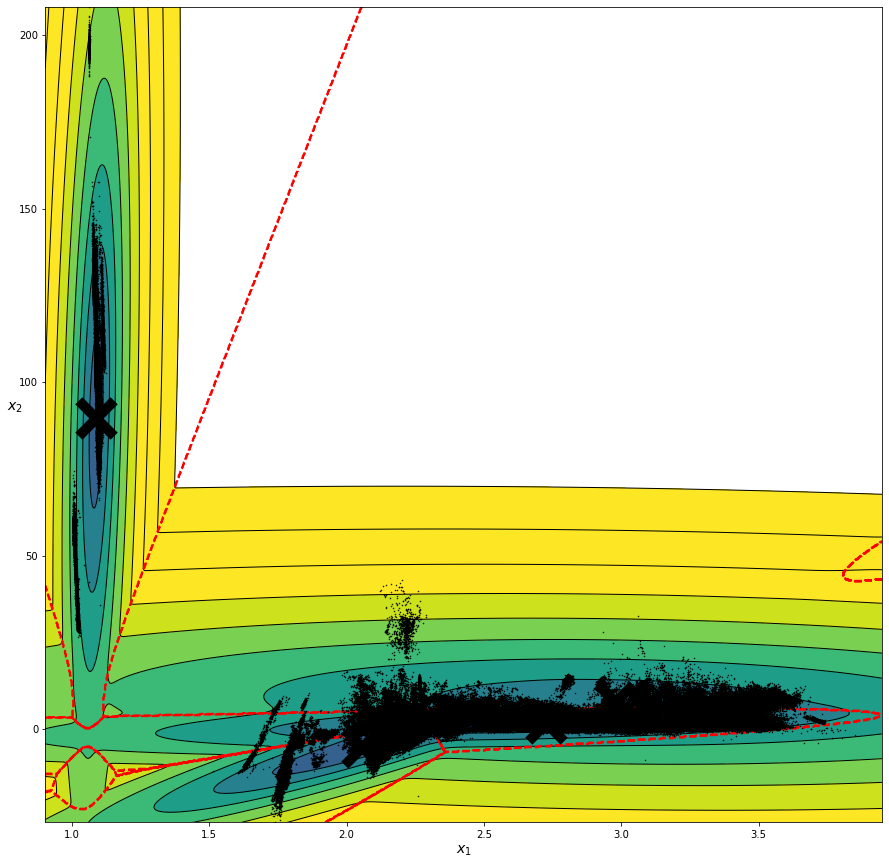

In [68]:
plt.figure(figsize=(15, 15))

plot_gaussian_mixture(gm,np.array(train_top2best))

plt.show()

In [69]:
GMM_per_k = [GaussianMixture(n_components=k, max_iter = 30, random_state=27).fit(train_top2best)
                for k in range(1, 15)]

D:\anaconda\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


<ipython-input-67-48005c1f8035>:21: UserWarning: No contour levels were found within the data range.
  plt.contour(xx, yy, Z,


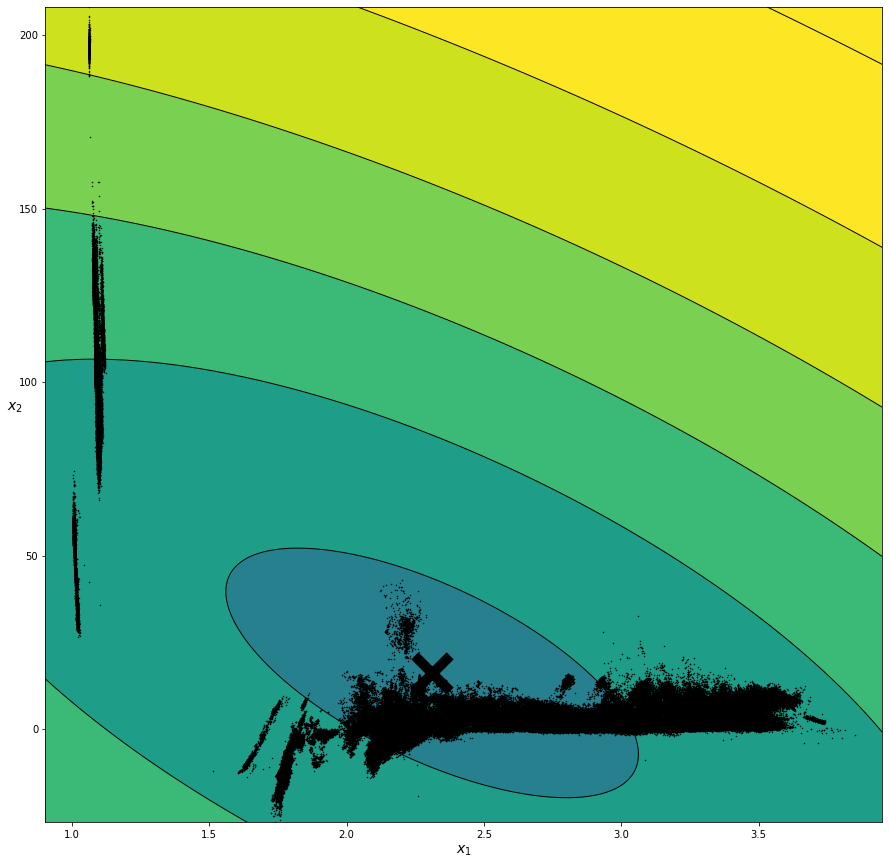

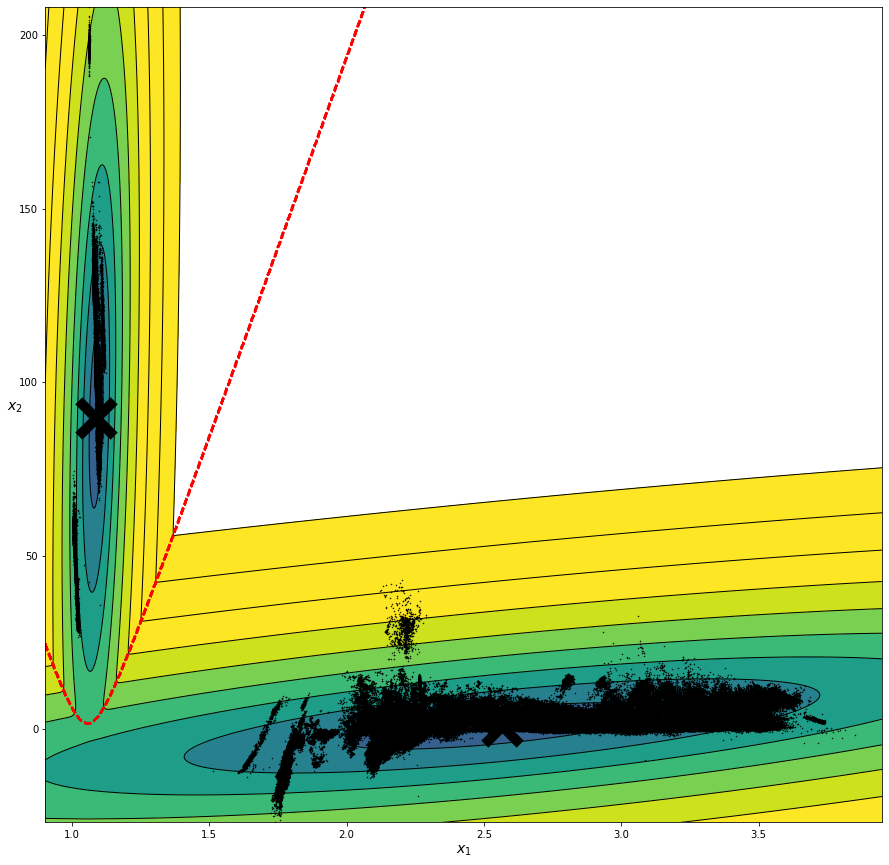

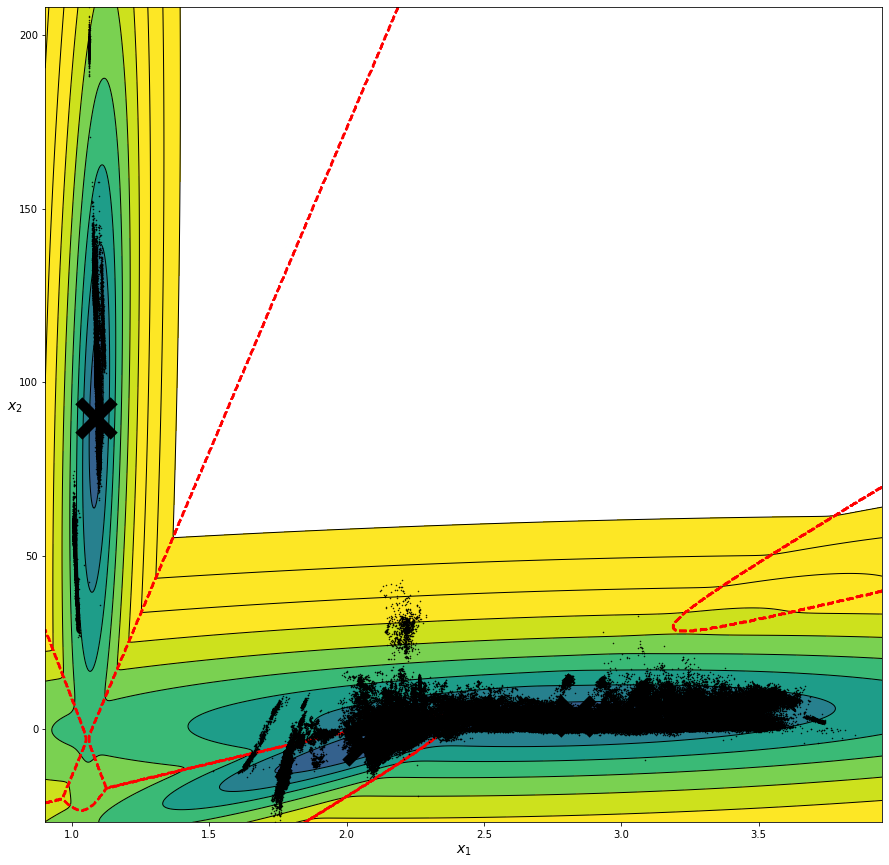

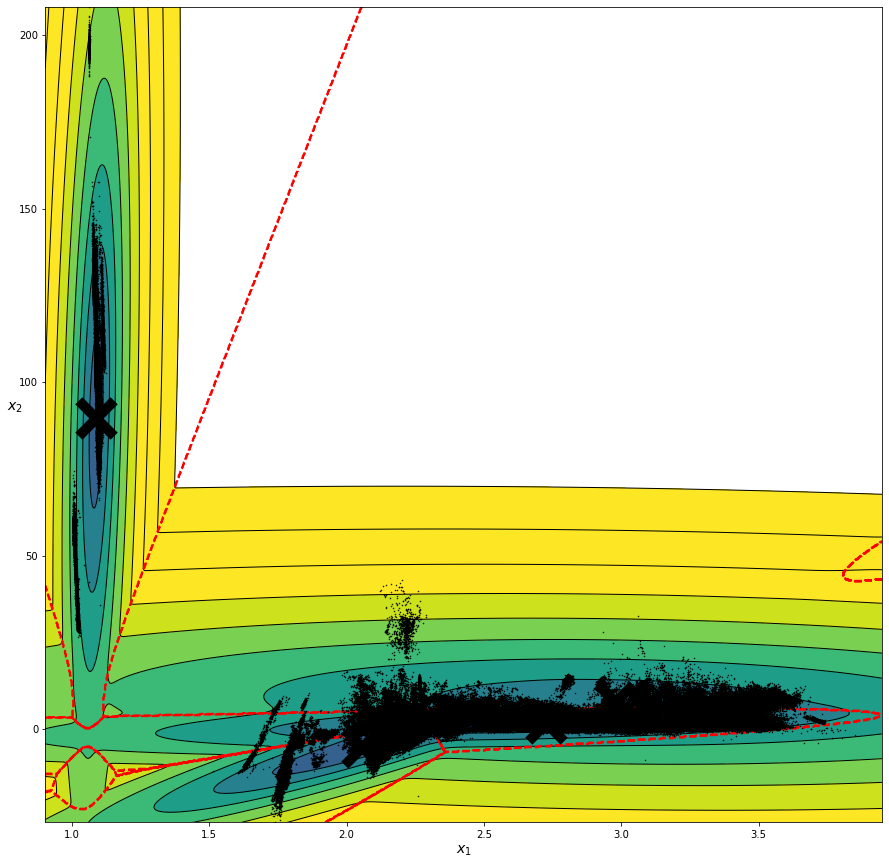

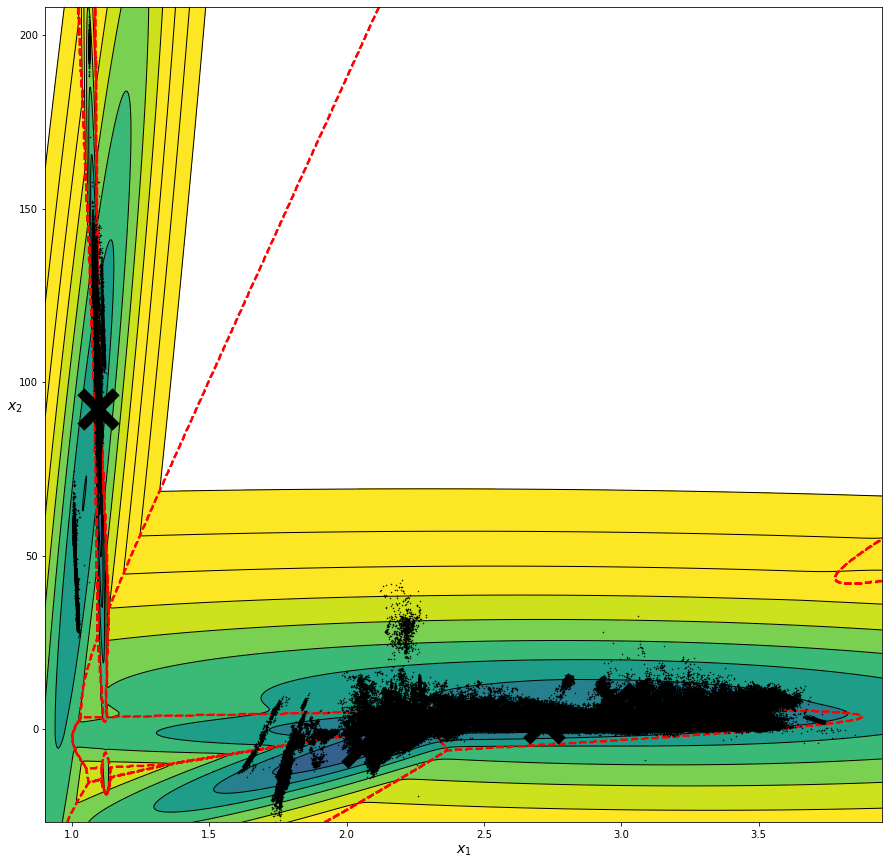

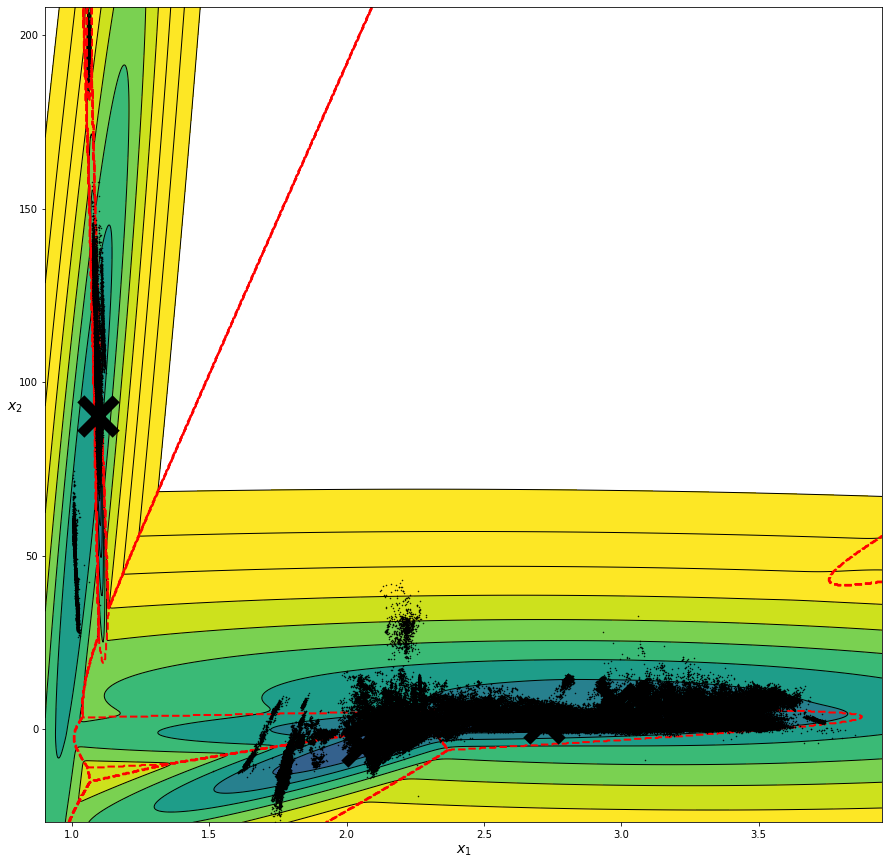

<ipython-input-67-48005c1f8035>:11: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contourf(xx, yy, Z,
<ipython-input-67-48005c1f8035>:14: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contour(xx, yy, Z,


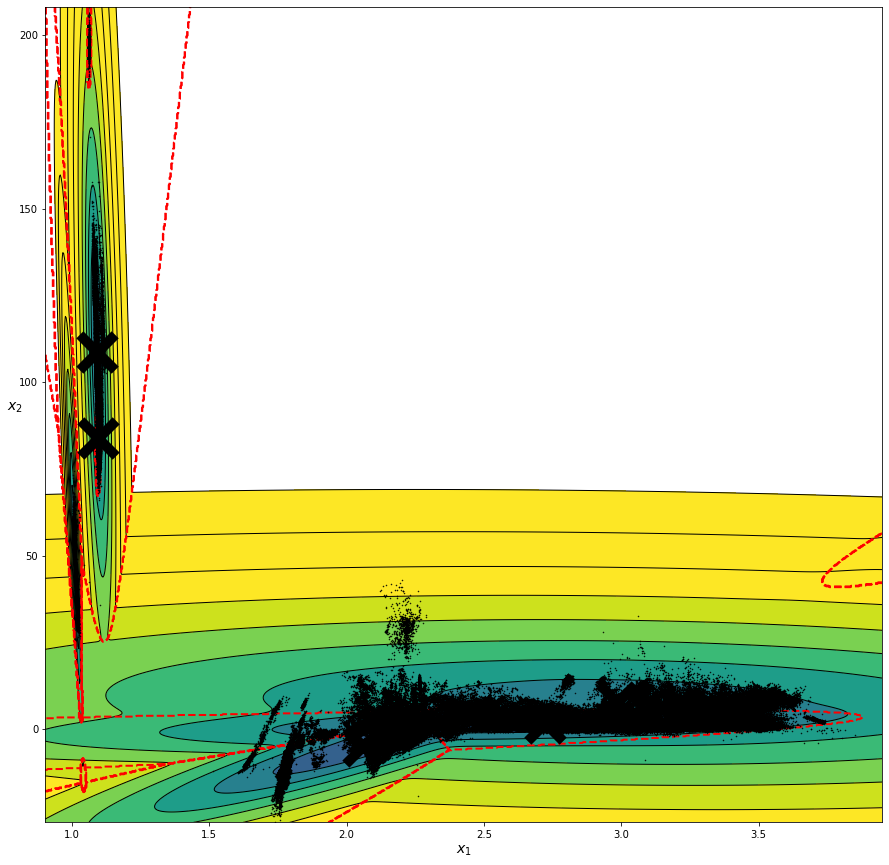

<ipython-input-67-48005c1f8035>:11: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contourf(xx, yy, Z,
<ipython-input-67-48005c1f8035>:14: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contour(xx, yy, Z,


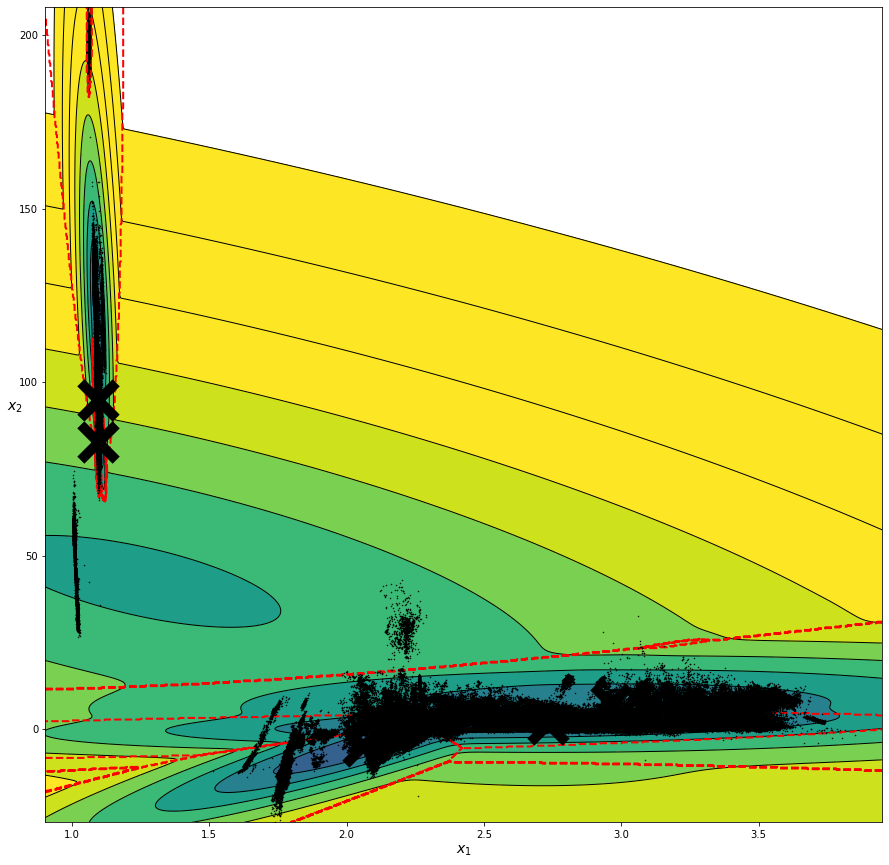

<ipython-input-67-48005c1f8035>:11: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contourf(xx, yy, Z,
<ipython-input-67-48005c1f8035>:14: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contour(xx, yy, Z,


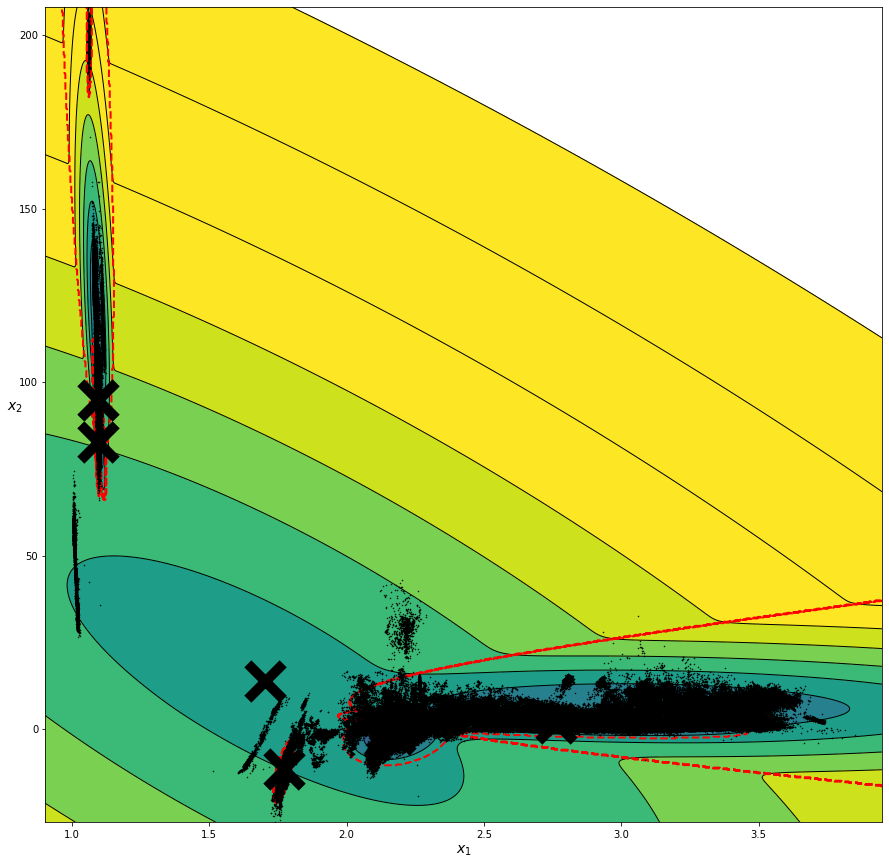

<ipython-input-67-48005c1f8035>:11: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contourf(xx, yy, Z,
<ipython-input-67-48005c1f8035>:14: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contour(xx, yy, Z,


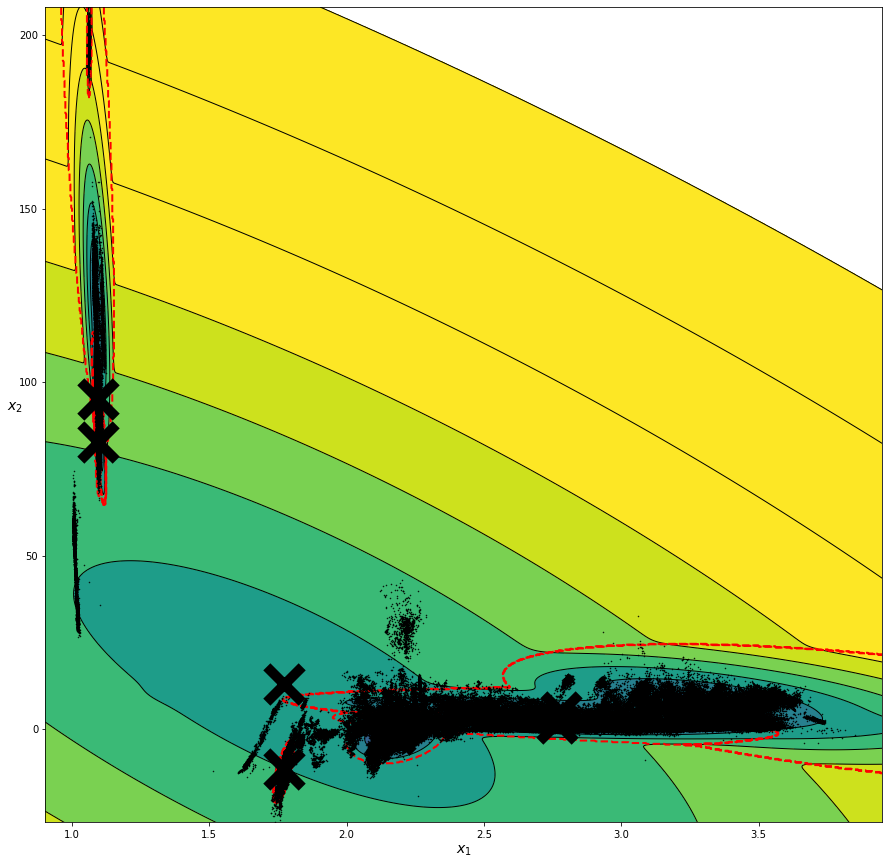

<ipython-input-67-48005c1f8035>:11: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contourf(xx, yy, Z,
<ipython-input-67-48005c1f8035>:14: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contour(xx, yy, Z,


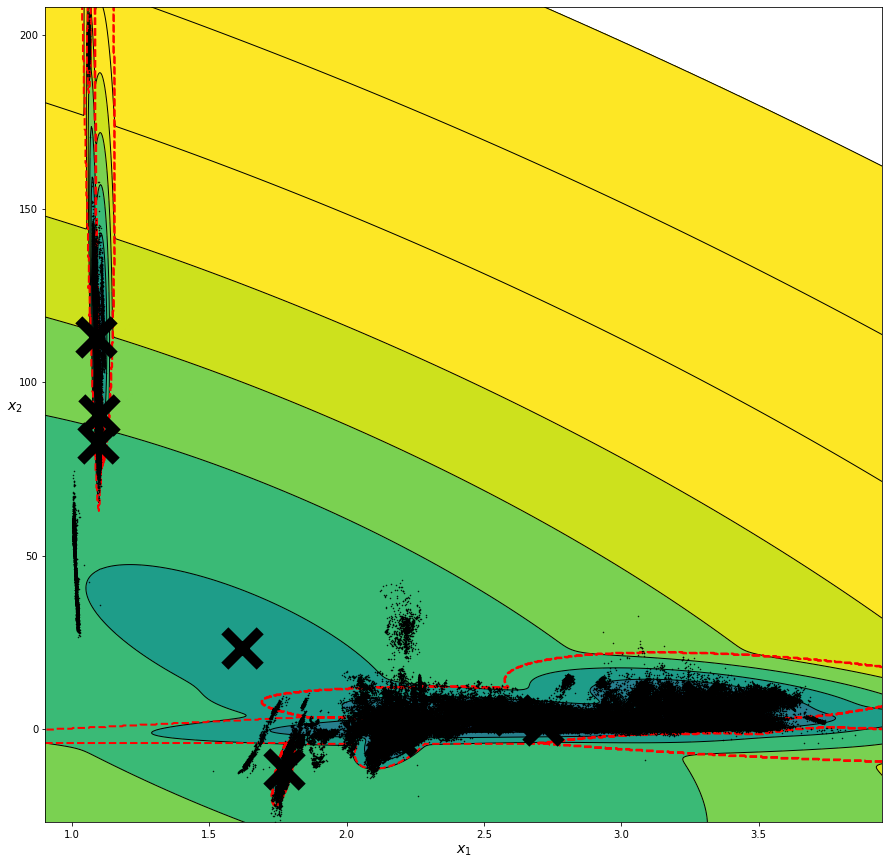

<ipython-input-67-48005c1f8035>:11: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contourf(xx, yy, Z,
<ipython-input-67-48005c1f8035>:14: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contour(xx, yy, Z,


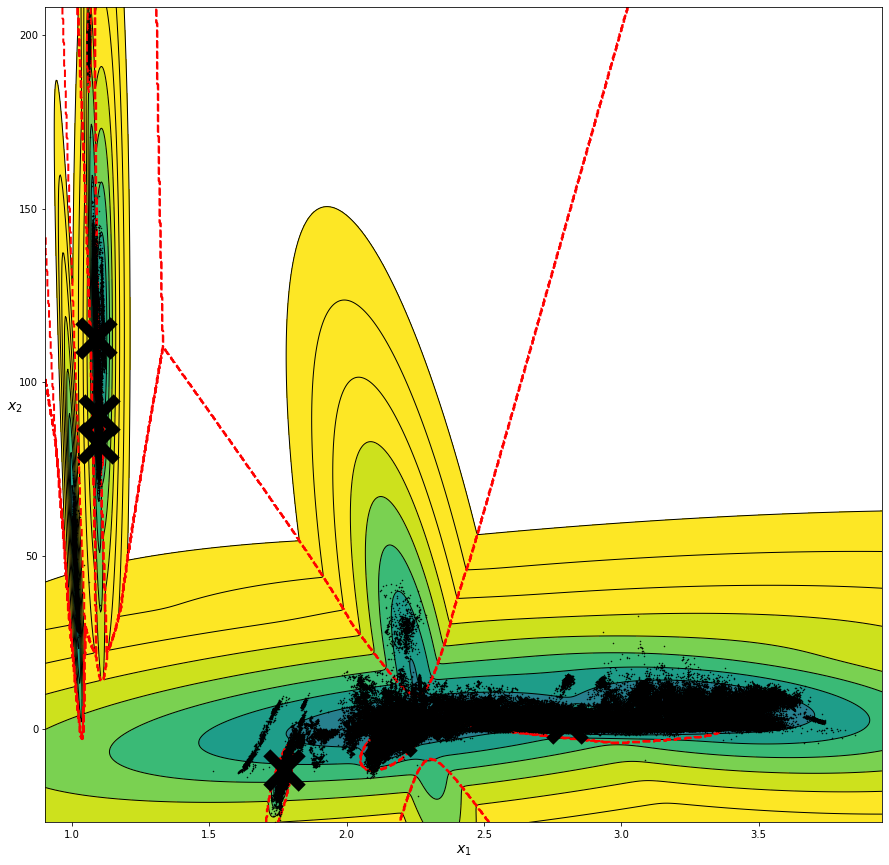

<ipython-input-67-48005c1f8035>:11: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contourf(xx, yy, Z,
<ipython-input-67-48005c1f8035>:14: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contour(xx, yy, Z,


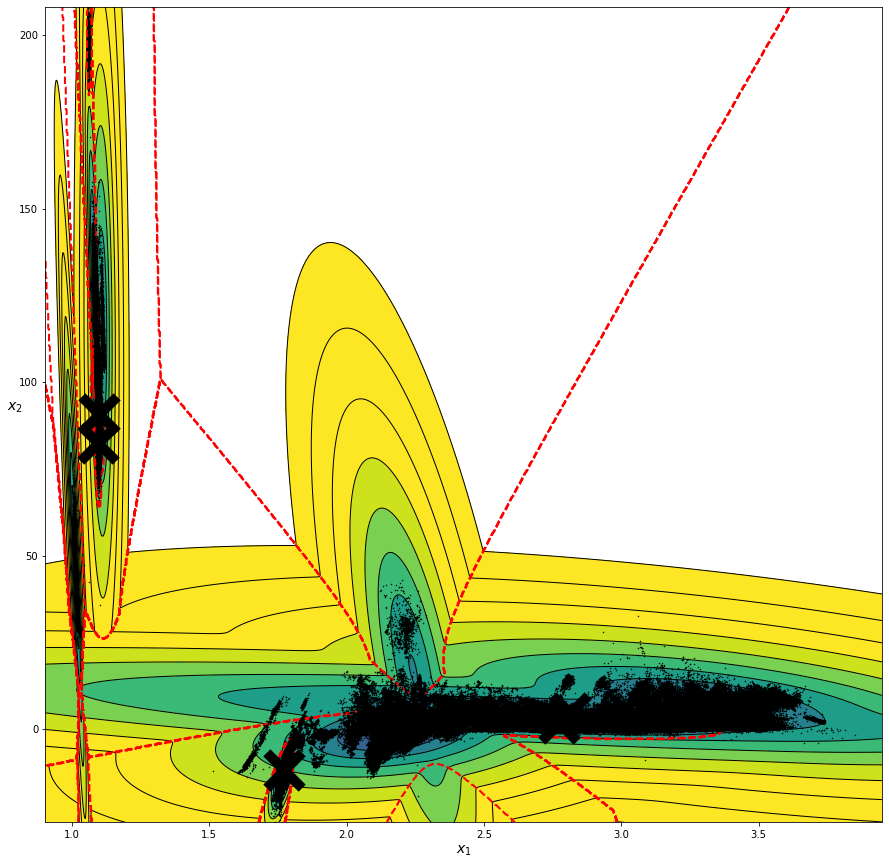

<ipython-input-67-48005c1f8035>:11: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contourf(xx, yy, Z,
<ipython-input-67-48005c1f8035>:14: UserWarning: Log scale: values of z <= 0 have been masked
  plt.contour(xx, yy, Z,


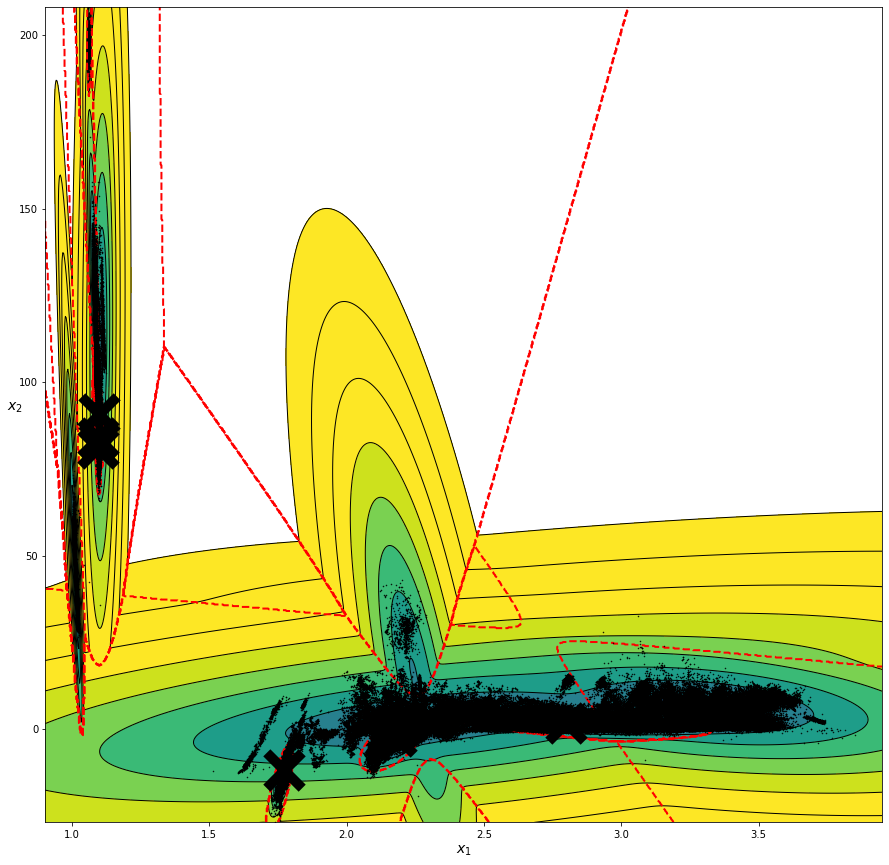

In [70]:
for model in GMM_per_k:
    plt.figure(figsize=(15, 15))
    plot_gaussian_mixture(model,np.array(train_top2best))
    plt.show()

In [71]:
bics = [model.bic(train_top2best) for model in GMM_per_k]
aics = [model.aic(train_top2best) for model in GMM_per_k]

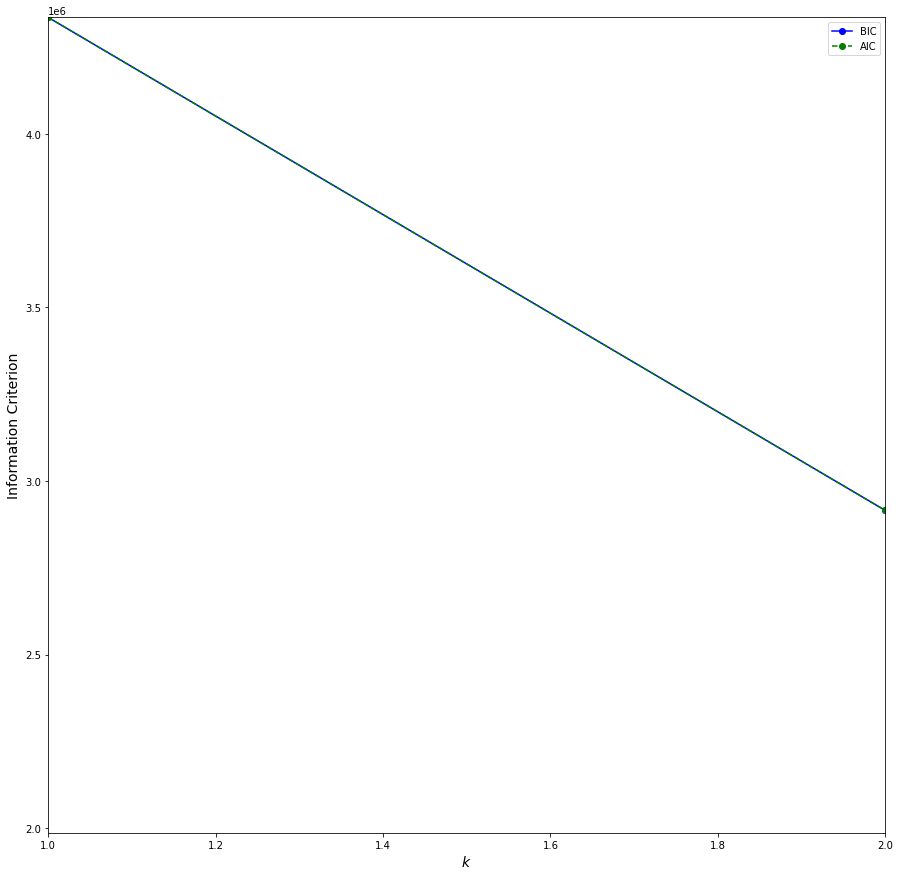

In [72]:
plt.figure(figsize=(15, 15))
plt.plot(range(1, 15), bics, "bo-", label="BIC")
plt.plot(range(1, 15), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 2, np.min(aics) - 50, np.max(aics) + 50])
# plt.annotate('Minimum',
#              xy=(3, bics[2]),
#              xytext=(0.35, 0.6),
#              textcoords='figure fraction',
#              fontsize=14,
#              arrowprops=dict(facecolor='black', shrink=0.1)
#             )
plt.legend()
plt.show()

[Text(957.6402331857898, 1756.5075000000002, 'X[22] <= 1.845\ngini = 0.429\nsamples = 372725\nvalue = [256579, 116146]'),
 Text(430.5689939996119, 1681.7625, 'X[22] <= -2.964\ngini = 0.444\nsamples = 171076\nvalue = [56839, 114237]'),
 Text(106.09882797458606, 1607.0175000000002, 'X[22] <= -3.022\ngini = 0.013\nsamples = 54630\nvalue = [54266, 364]'),
 Text(48.93914613015017, 1532.2725, 'X[22] <= -3.154\ngini = 0.006\nsamples = 54078\nvalue = [53906, 172]'),
 Text(24.934886407393147, 1457.5275000000001, 'X[20] <= 4.906\ngini = 0.001\nsamples = 52939\nvalue = [52909, 30]'),
 Text(17.2535232961109, 1382.7825, 'X[22] <= -3.216\ngini = 0.001\nsamples = 52927\nvalue = [52902, 25]'),
 Text(15.362726222564497, 1308.0375000000001, 'gini = 0.0\nsamples = 52351\nvalue = [52351, 0]'),
 Text(19.144320369657297, 1308.0375000000001, 'X[17] <= 2.216\ngini = 0.083\nsamples = 576\nvalue = [551, 25]'),
 Text(9.453985367731999, 1233.2925, 'X[25] <= 0.373\ngini = 0.03\nsamples = 526\nvalue = [518, 8]'),
 

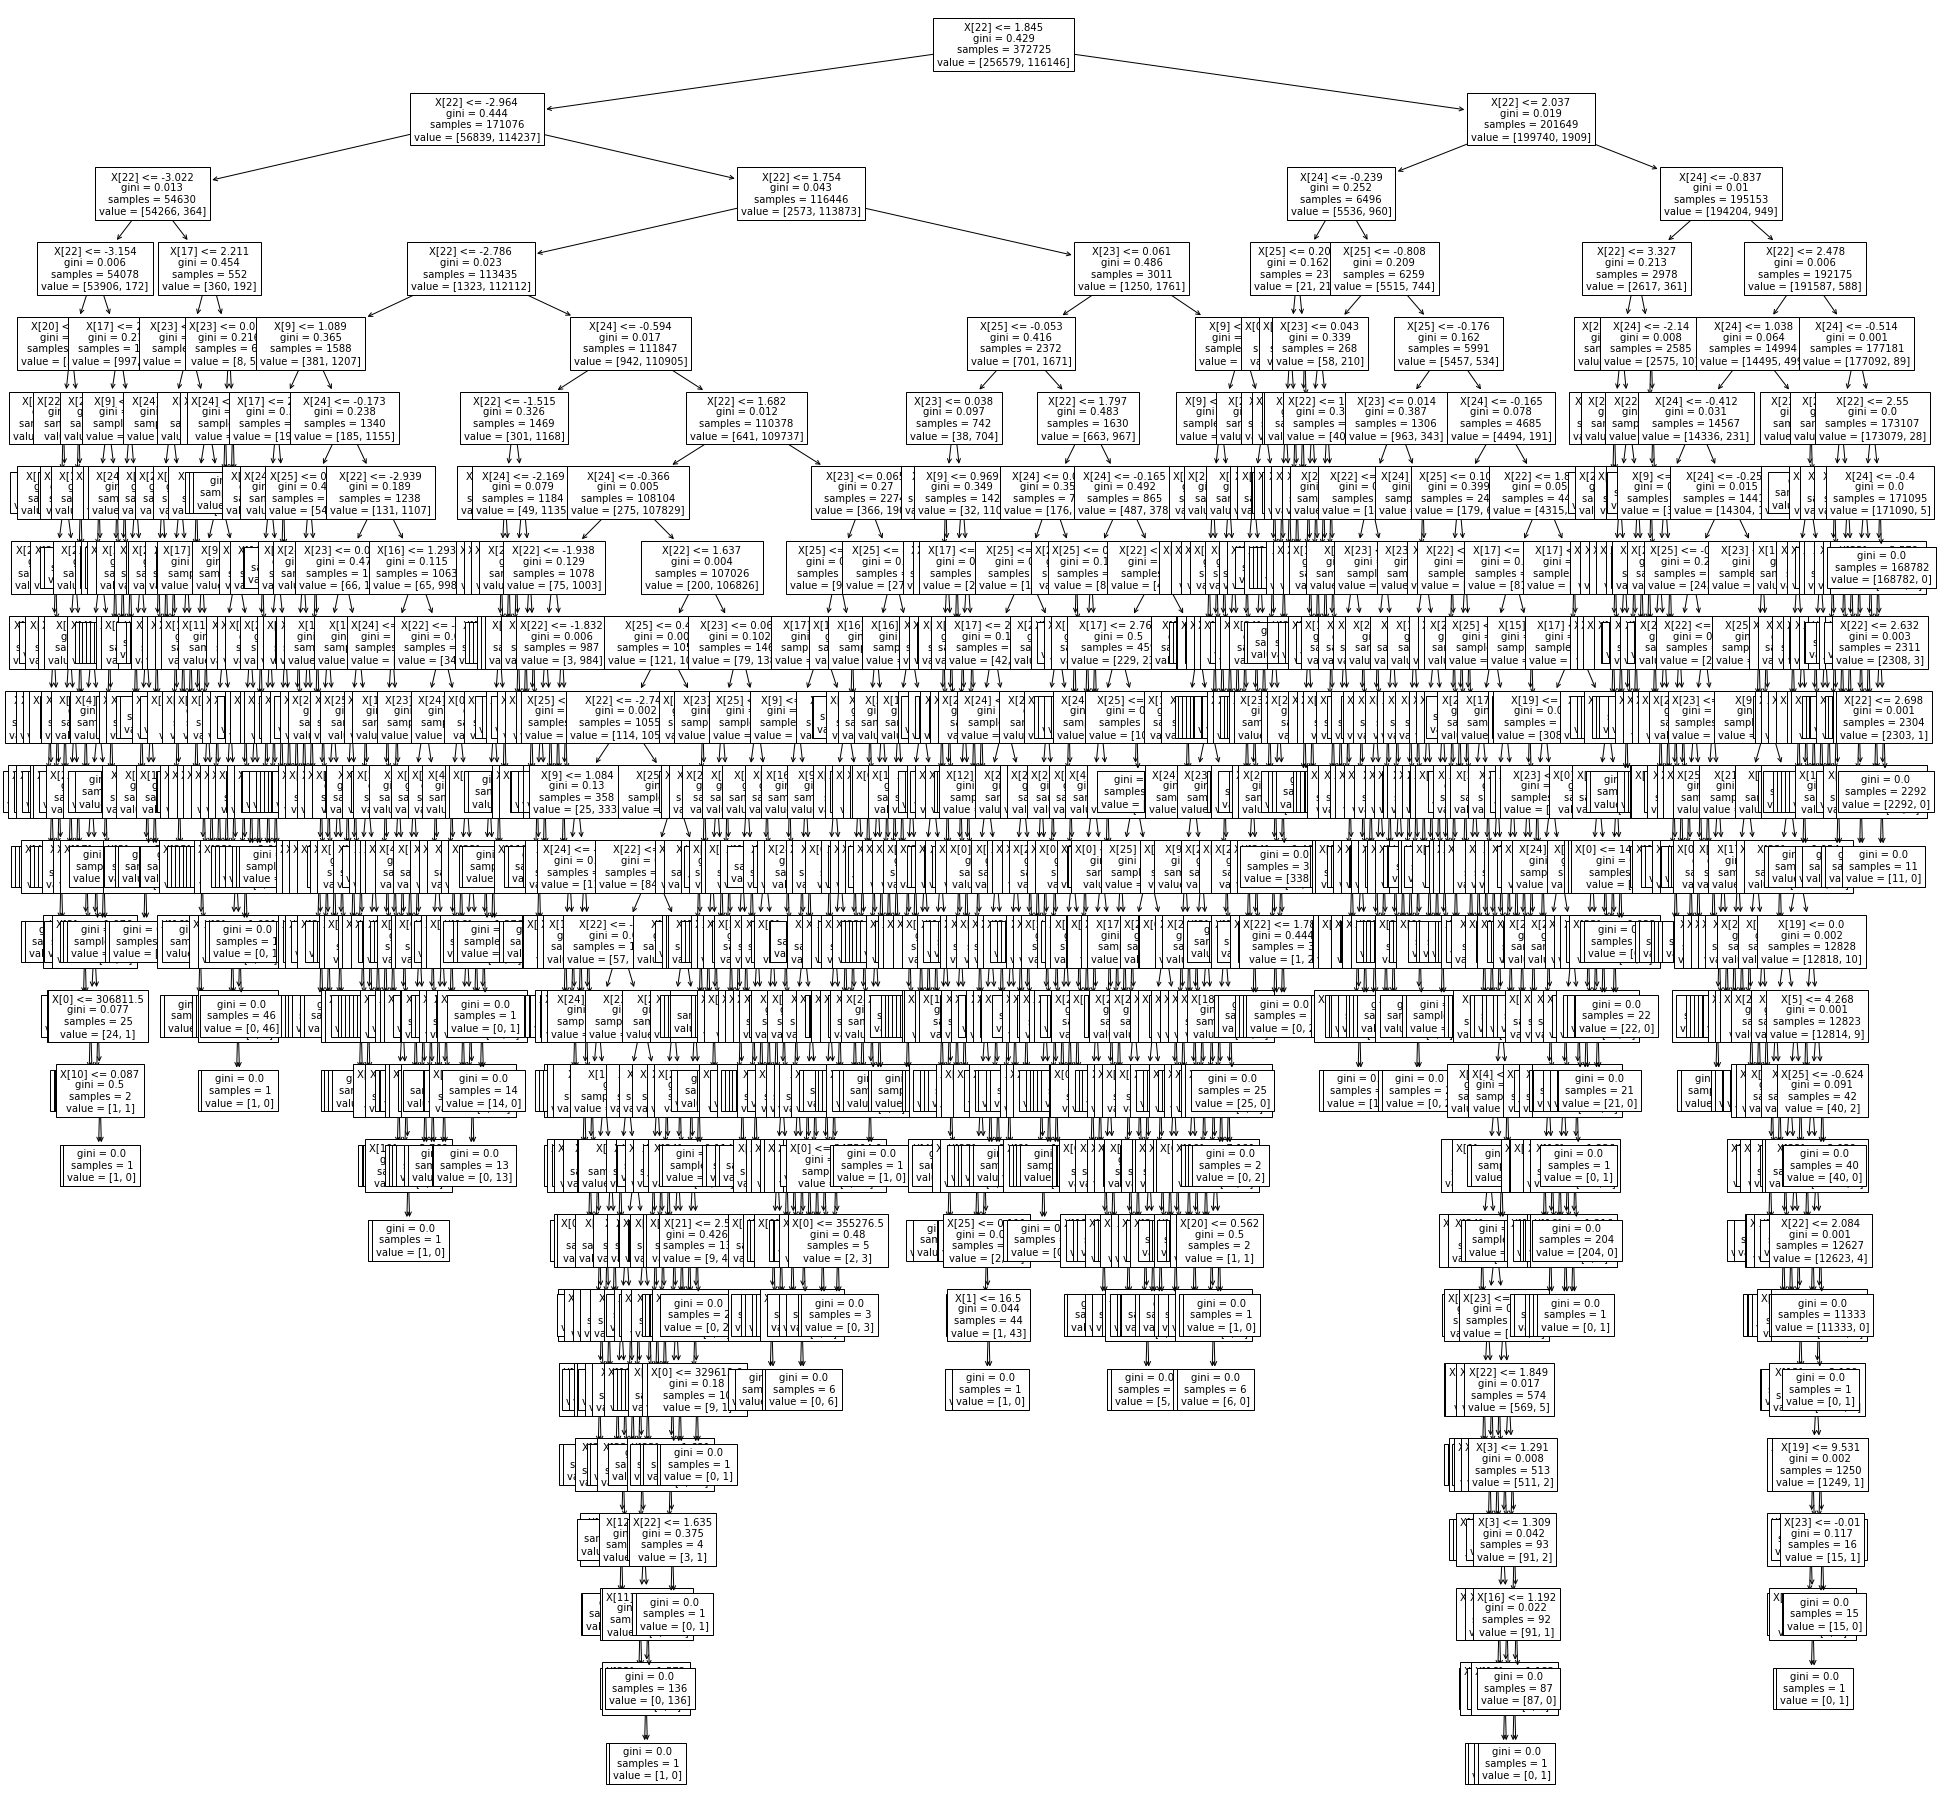

In [73]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

tree_clf_J48 = DecisionTreeClassifier(random_state=23)
tree_clf_J48.fit(train_new, outcome_train_new[:,5])
plt.figure(figsize=(33,33))
plot_tree(tree_clf_J48, fontsize=10)

In [74]:
def performance_DecisionTree(column, train_new, outcome_train_new, tree_clf_J48):
    
    result_Tree = cross_val_score(tree_clf_J48, train_new, np.ravel(outcome_train_new[:,column]), cv=10, scoring="accuracy")
    
    print('Decision Tree J48 accuracy: ', result_Tree)
    
    out_DecisionTree_pred = cross_val_predict(tree_clf_J48, train_new, np.ravel(outcome_train_new[:,column]), cv=10)
    
    print('Confusion matrix: \n', confusion_matrix(np.ravel(outcome_train_new[:,column]), out_DecisionTree_pred))
    print('Precision: ', precision_score(np.ravel(outcome_train_new[:,column]), out_DecisionTree_pred))
    print('Recall: ', recall_score(np.ravel(outcome_train_new[:,column]), out_DecisionTree_pred))
    print('F score: ', f1_score(np.ravel(outcome_train_new[:,column]), out_DecisionTree_pred))
    
    out_DecisionTree = cross_val_predict(tree_clf_J48, train_new, np.ravel(outcome_train_new[:,column]), cv=10, method="predict_proba")
    test_score = out_DecisionTree[:, 1]
    fpr, tpr, thresholds = roc_curve(np.ravel(outcome_train_new[:,column]), test_score)

    def plot_roc_curve(fpr, tpr, label=None):
        plt.plot(fpr, tpr, linewidth=2, label=label)
        plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
        plt.axis([0, 1, 0, 1])                                    
        plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
        plt.ylabel('True Positive Rate (Recall)', fontsize=16)  
        plt.grid(True)                                           

    plot_roc_curve(fpr, tpr)
    plt.show()

    print('AUC score: ', roc_auc_score(np.ravel(outcome_train_new[:,column]), test_score))

Decision Tree J48 accuracy:  [0.99315859 0.99581466 0.99466101 0.99181713 0.99554637 0.99533162
 0.99511698 0.99640481 0.99559991 0.4623578 ]
Confusion matrix: 
 [[235815  20764]
 [  1010 115136]]
Precision:  0.8472111846946284
Recall:  0.9913040483529351
F score:  0.9136110075145012


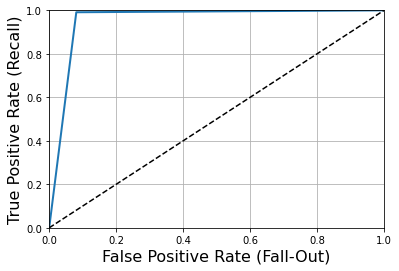

AUC score:  0.9551888529894257


In [75]:
performance_DecisionTree(5, train_new, outcome_train_new, tree_clf_J48)

In [76]:
def performance_DecisionTree_testdata(column, test_new, outcome_test_new, tree_clf_J48):
    
    result_Tree = tree_clf_J48.score(test_new, np.ravel(outcome_test_new[:,column]))
    
    print('Decision Tree J48 accuracy: ', result_Tree)
    
    out_DecisionTree_pred = tree_clf_J48.predict(test_new)
    
    print('Confusion matrix: \n', confusion_matrix(np.ravel(outcome_test_new[:,column]), out_DecisionTree_pred))
    print('Precision: ', precision_score(np.ravel(outcome_test_new[:,column]), out_DecisionTree_pred))
    print('Recall: ', recall_score(np.ravel(outcome_test_new[:,column]), out_DecisionTree_pred))
    print('F score: ', f1_score(np.ravel(outcome_test_new[:,column]), out_DecisionTree_pred))
    
    out_DecisionTree = tree_clf_J48.predict_proba(test_new)
    test_score = out_DecisionTree[:, 1]
    fpr, tpr, thresholds = roc_curve(np.ravel(outcome_test_new[:,column]), test_score)

    def plot_roc_curve(fpr, tpr, label=None):
        plt.plot(fpr, tpr, linewidth=2, label=label)
        plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
        plt.axis([0, 1, 0, 1])                                    
        plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
        plt.ylabel('True Positive Rate (Recall)', fontsize=16)  
        plt.grid(True)                                           

    plot_roc_curve(fpr, tpr)
    plt.show()

    print('AUC score: ', roc_auc_score(np.ravel(outcome_test_new[:,column]), test_score))

Decision Tree J48 accuracy:  0.9807688180120624
Confusion matrix: 
 [[62060   642]
 [ 1150 29330]]
Precision:  0.9785800080074737
Recall:  0.9622703412073491
F score:  0.9703566465956461


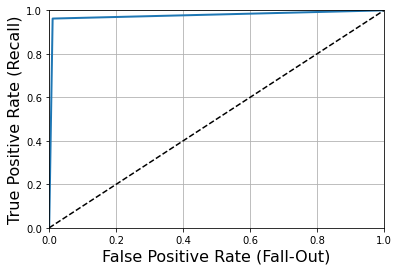

AUC score:  0.9760157166787599


In [77]:
performance_DecisionTree_testdata(4, test_new, outcome_test_new, tree_clf_J48)

Decision Tree J48 accuracy:  0.8488334656907986
Confusion matrix: 
 [[49713 12989]
 [ 1097 29383]]
Precision:  0.6934532238270557
Recall:  0.9640091863517061
F score:  0.8066490967989897


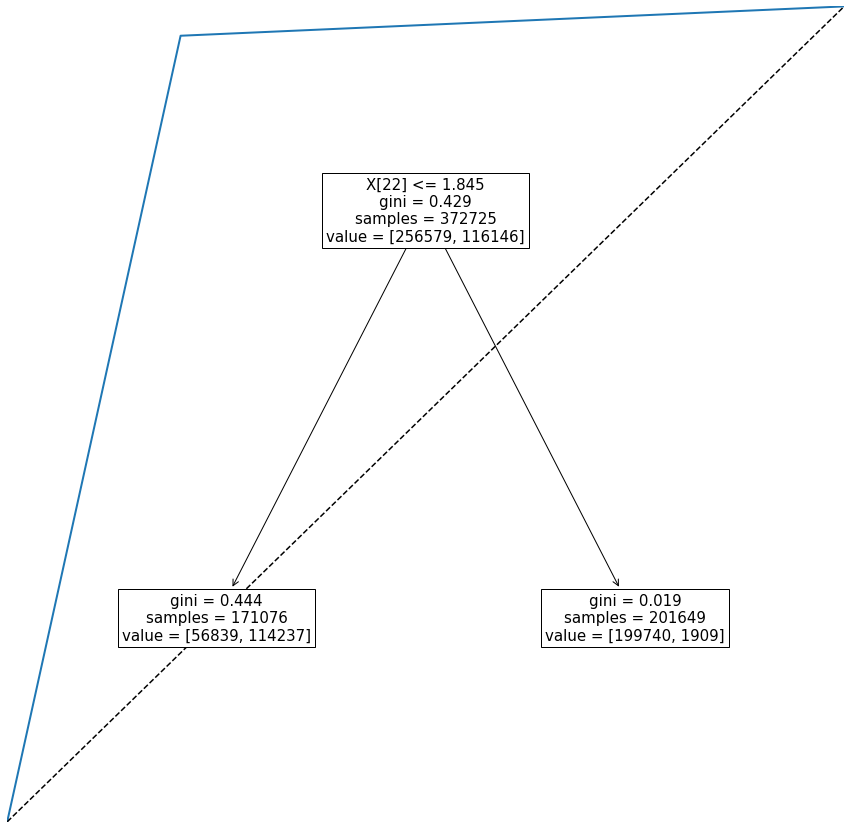

AUC score:  0.8784273548102506


In [78]:
tree_clf_J48 = DecisionTreeClassifier(max_depth = 1, random_state=23)
tree_clf_J48.fit(train_new, outcome_train_new[:,5])
plt.figure(figsize=(15,15))
plot_tree(tree_clf_J48, fontsize=15)
performance_DecisionTree_testdata(4, test_new, outcome_test_new, tree_clf_J48)

Decision Tree J48 accuracy:  0.9792878452920092
Confusion matrix: 
 [[62067   635]
 [ 1295 29185]]
Precision:  0.9787055667337358
Recall:  0.95751312335958
F score:  0.9679933665008292


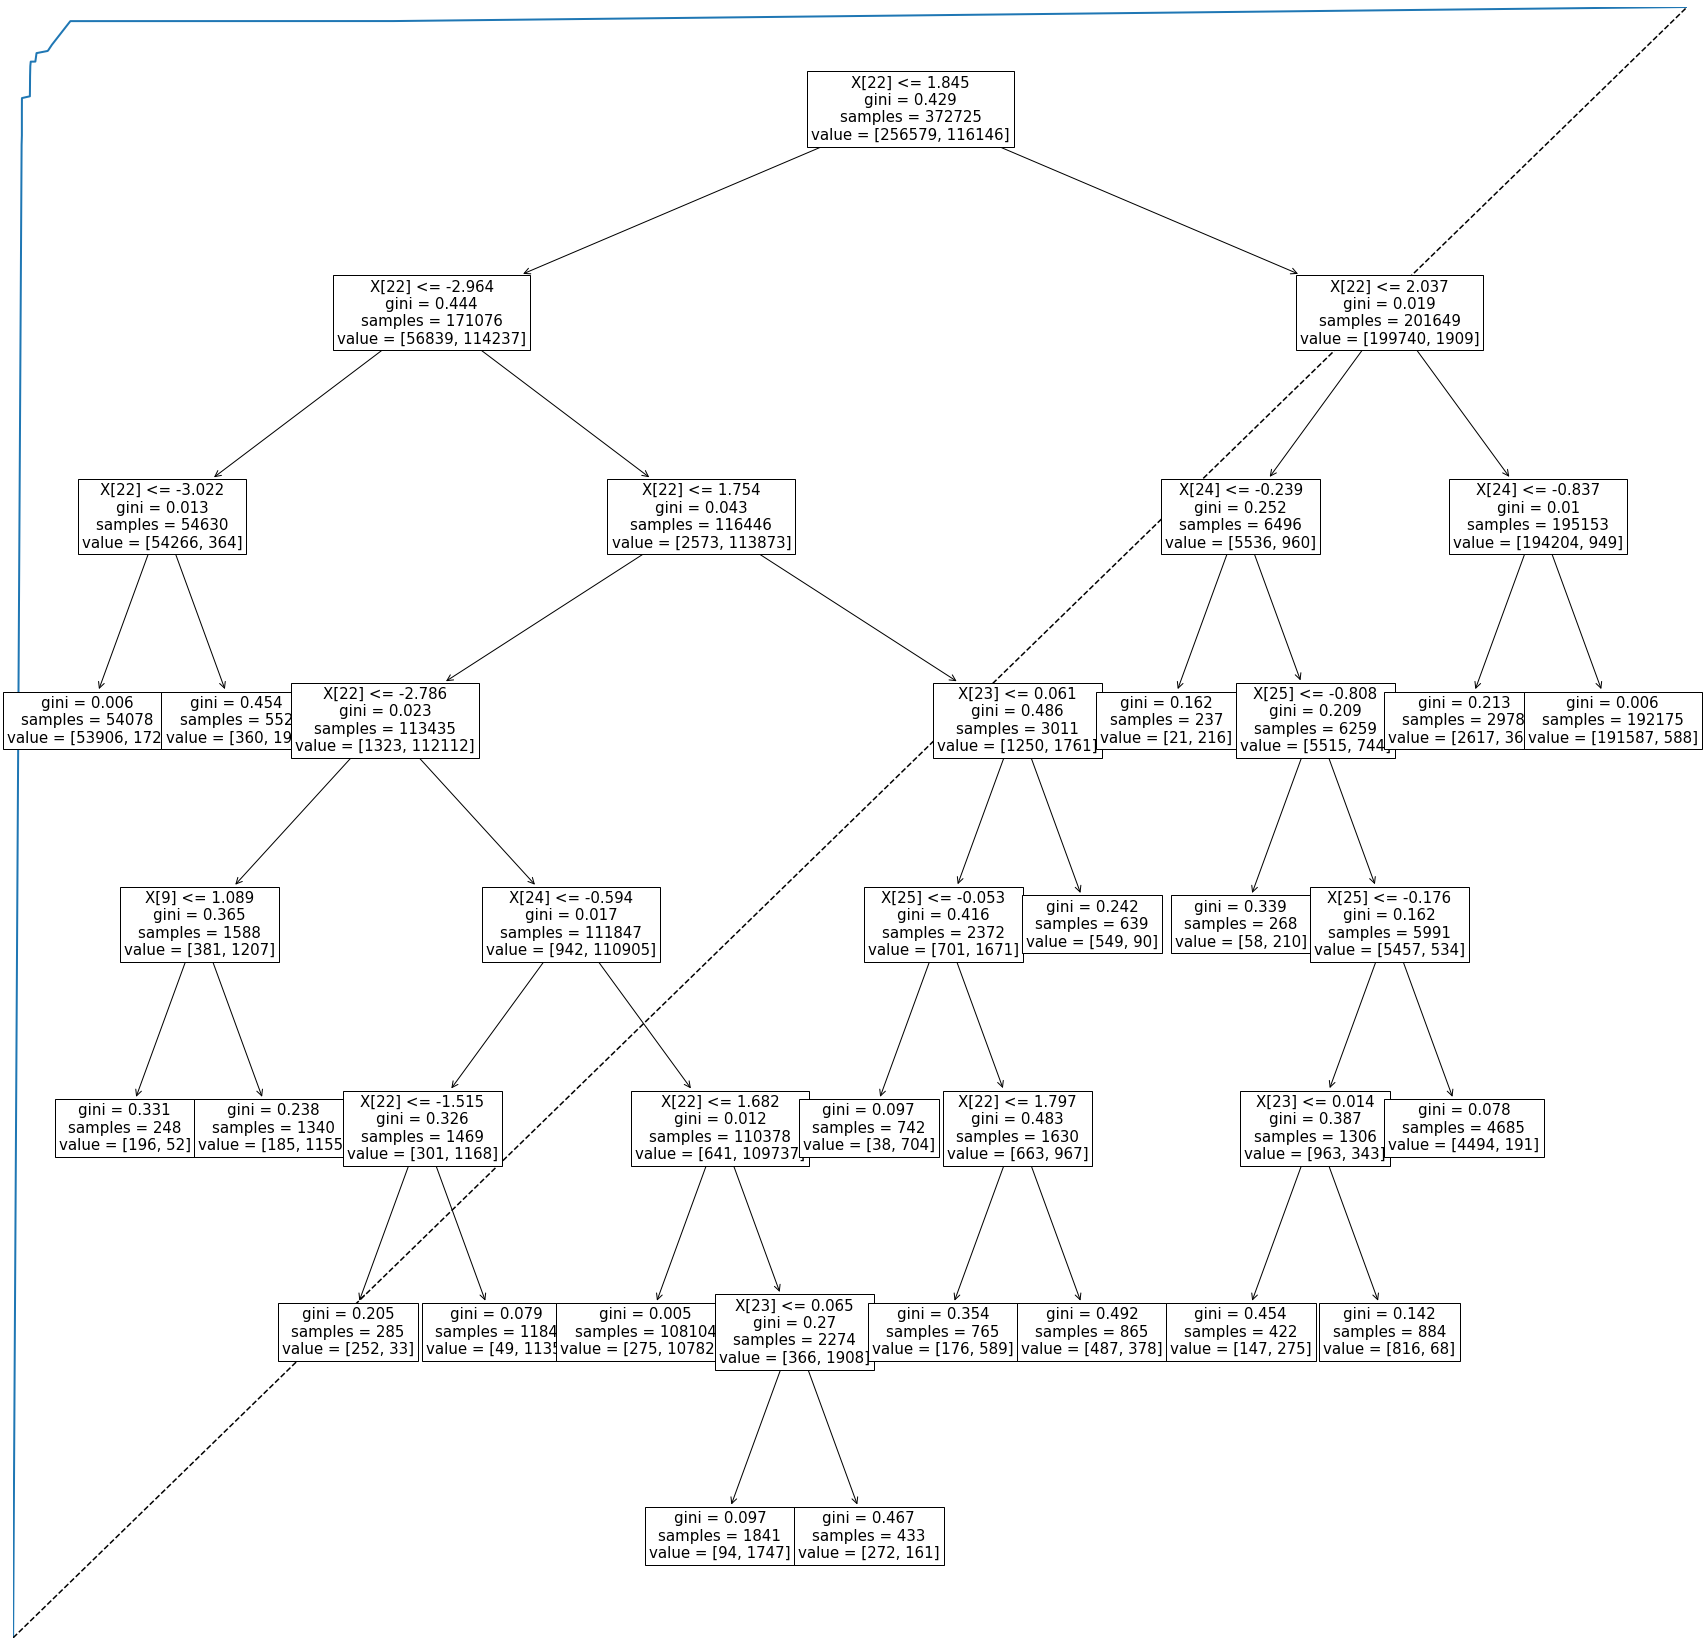

AUC score:  0.9914135540180855


In [79]:
tree_clf_J48 = DecisionTreeClassifier(max_depth = 10, min_samples_split=10, min_samples_leaf=10, max_leaf_nodes = 20, random_state=23)
tree_clf_J48.fit(train_new, outcome_train_new[:,5])
plt.figure(figsize=(30,30))
plot_tree(tree_clf_J48, fontsize=15)
performance_DecisionTree_testdata(4, test_new, outcome_test_new, tree_clf_J48)

In [80]:
precent30 = (372725*7) // 10
precent60 = (372725*4) // 10
temp30 = train_new.iloc[precent30:,:]
train_new_30 = train_new.iloc[:precent30,:]
test_new_30 = np.vstack((test_new, temp30))
temp30 = outcome_train_new[precent30:,:]
outcome_train_new_30 = outcome_train_new[:precent30,:]
outcome_test_new_30 = np.vstack((outcome_test_new,temp30))

temp60 = train_new.iloc[precent60:,:]
train_new_60 = train_new.iloc[:precent60,:]
test_new_60 = np.vstack((test_new, temp60))
temp60 = outcome_train_new[precent60:,:]
outcome_train_new_60 = outcome_train_new[:precent60,:]
outcome_test_new_60 = np.vstack((outcome_test_new,temp60))

Decision Tree J48 accuracy:  0.785809756097561
Confusion matrix: 
 [[131794  36676]
 [  7233  29297]]
Precision:  0.44407560668758433
Recall:  0.8019983575143718
F score:  0.5716320497936647


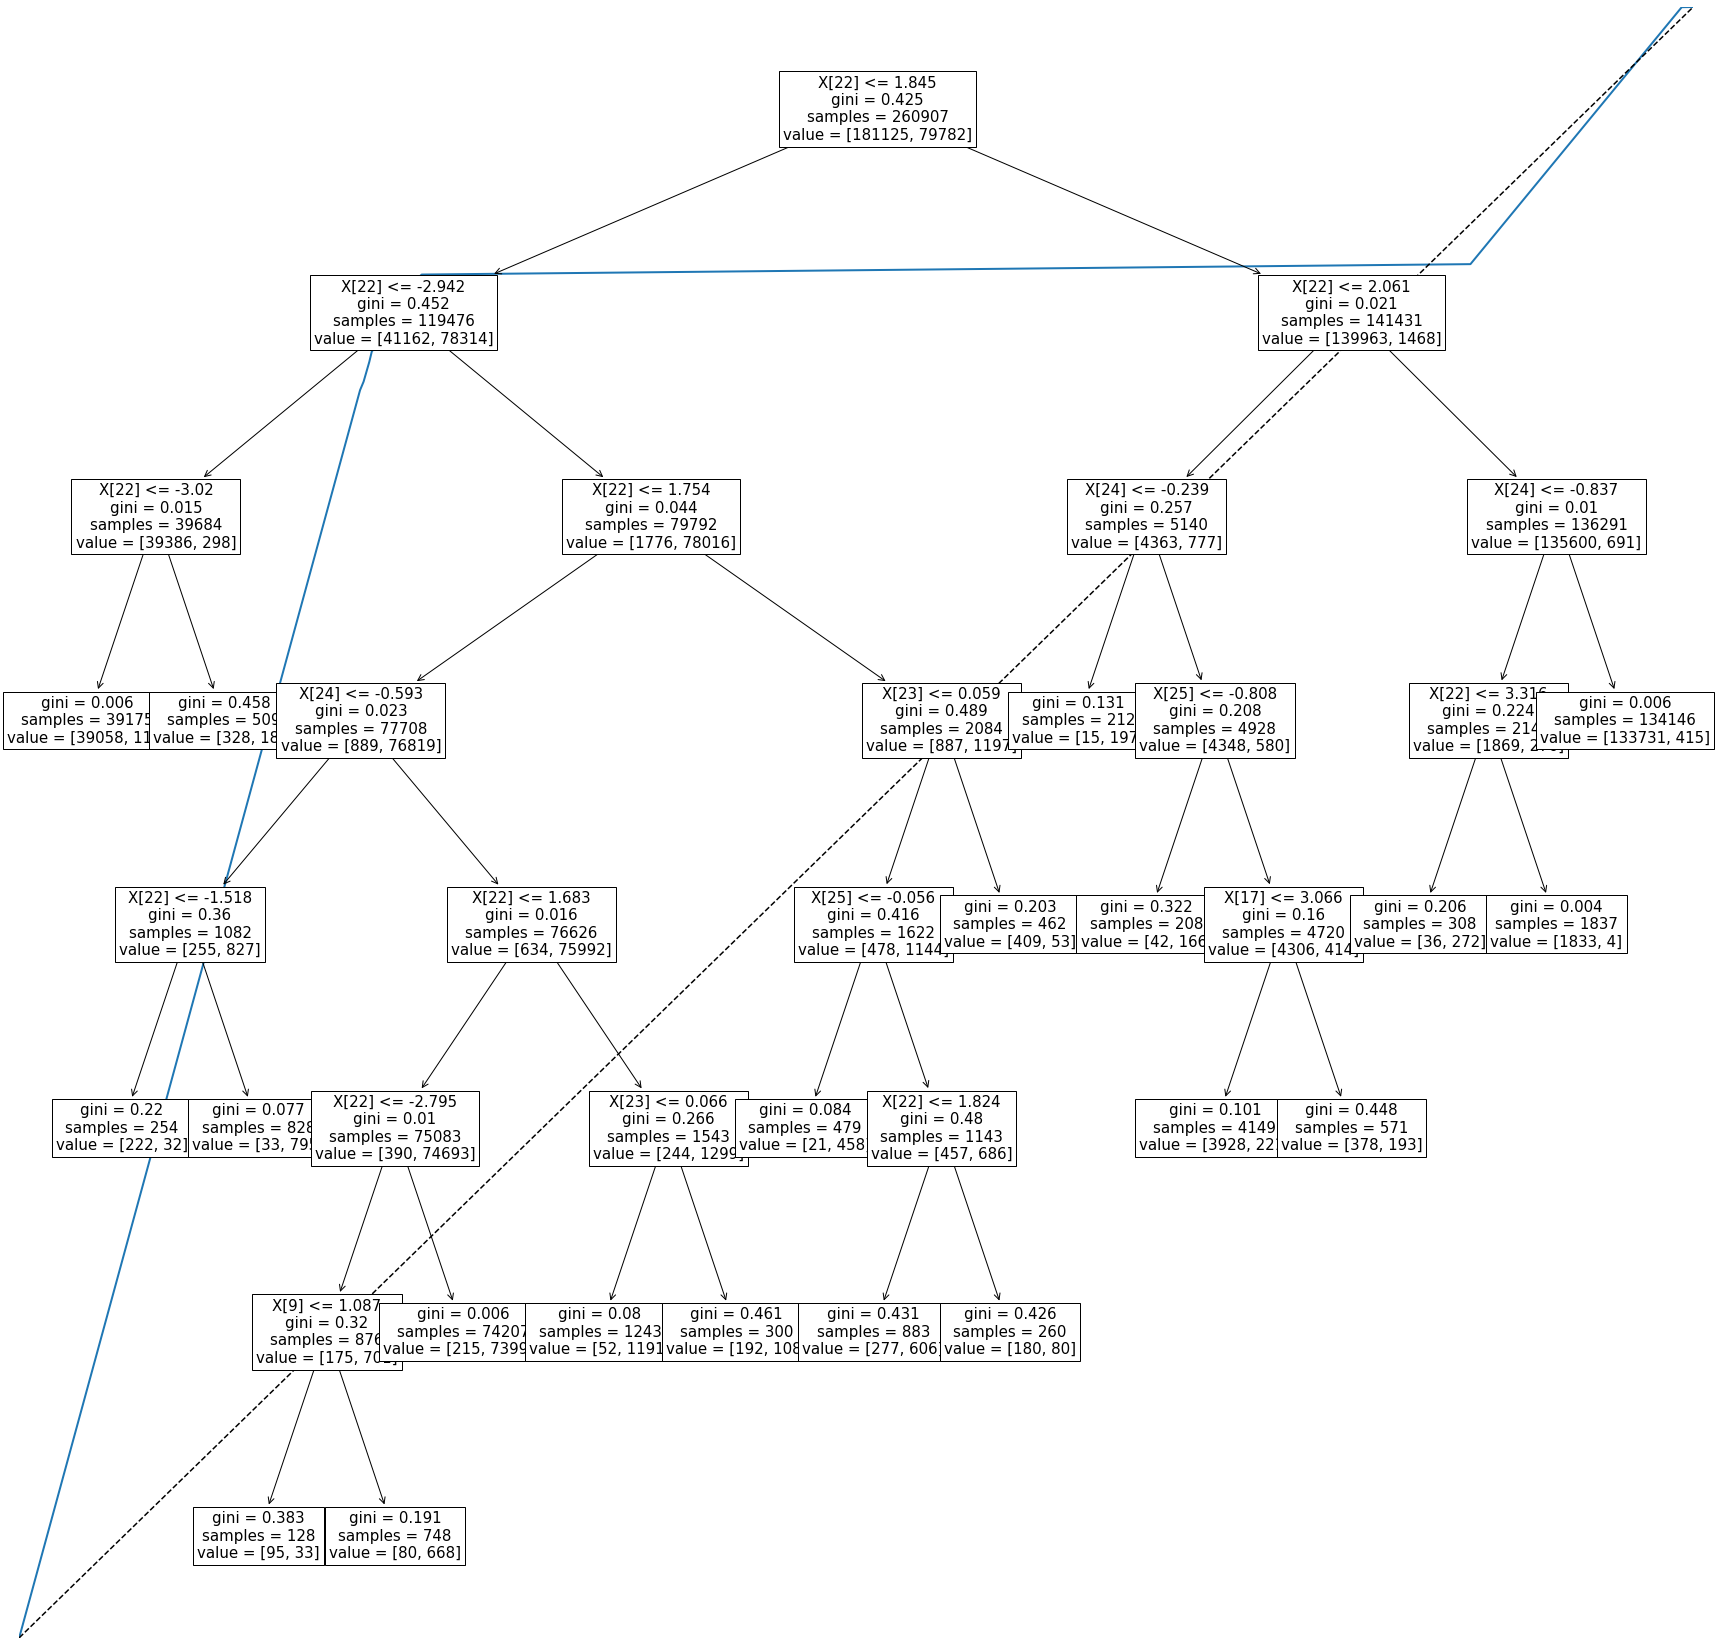

AUC score:  0.7564755328186687


In [81]:
tree_clf_J48 = DecisionTreeClassifier(max_depth = 10, min_samples_split=10, min_samples_leaf=10, max_leaf_nodes = 20, random_state=23)
tree_clf_J48.fit(train_new_30, outcome_train_new_30[:,5])
plt.figure(figsize=(30,30))
plot_tree(tree_clf_J48, fontsize=15)
performance_DecisionTree_testdata(4, test_new_30, outcome_test_new_30, tree_clf_J48)

Decision Tree J48 accuracy:  0.7286193607034976
Confusion matrix: 
 [[201111  72301]
 [ 13677  29728]]
Precision:  0.2913681404306619
Recall:  0.6848980532196751
F score:  0.4088177455065528


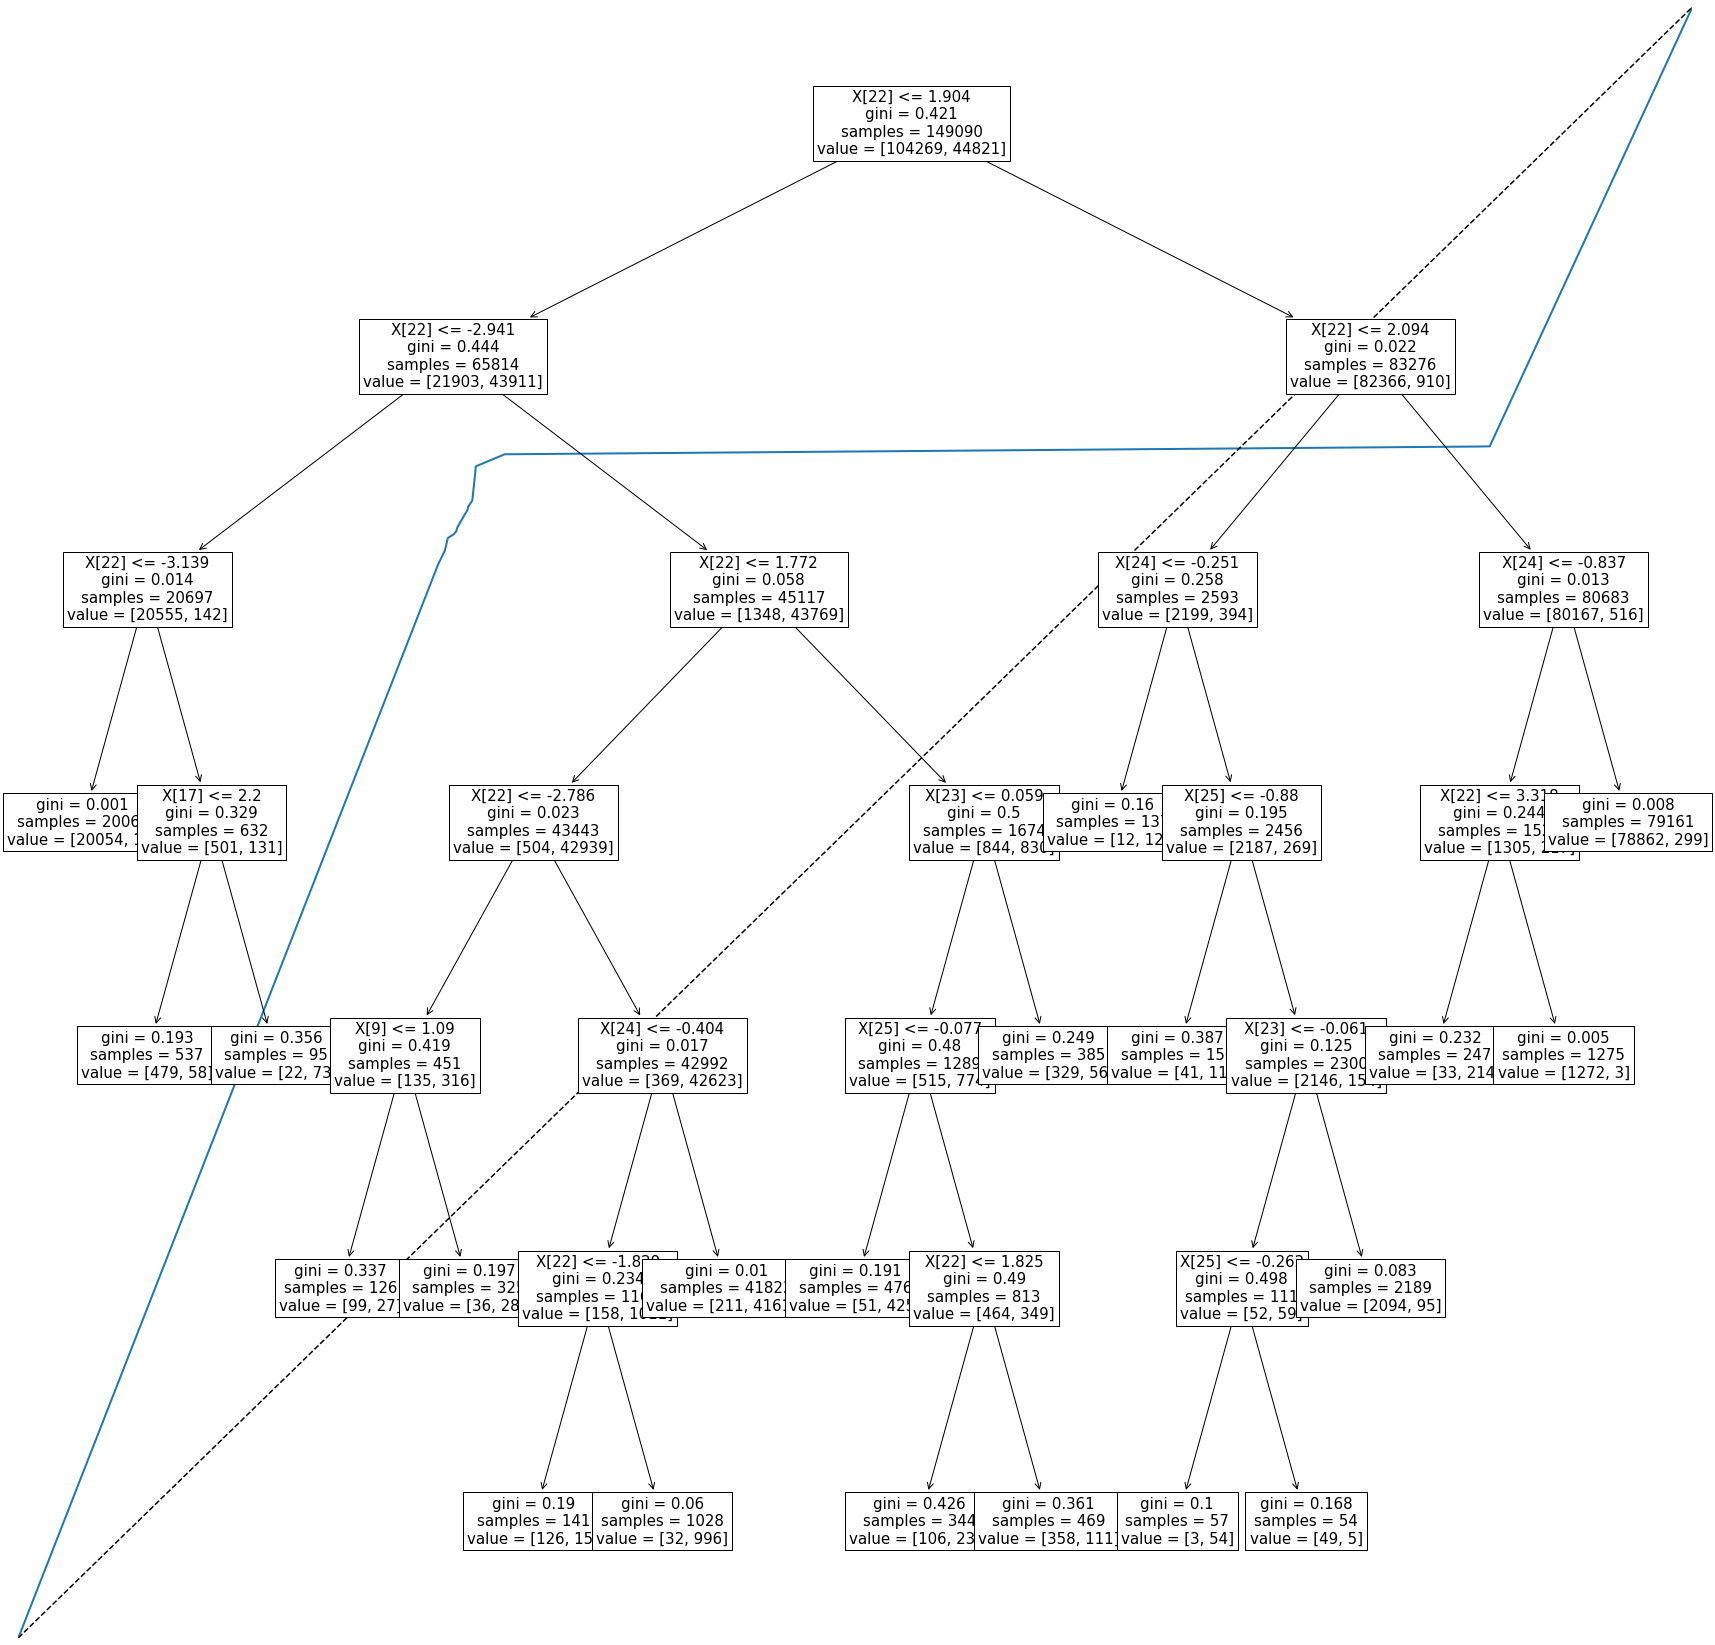

AUC score:  0.6435252088817688


In [82]:
tree_clf_J48 = DecisionTreeClassifier(max_depth = 10, min_samples_split=10, min_samples_leaf=10, max_leaf_nodes = 20, random_state=23)
tree_clf_J48.fit(train_new_60, outcome_train_new_60[:,5])
plt.figure(figsize=(30,30))
plot_tree(tree_clf_J48, fontsize=15)
performance_DecisionTree_testdata(4, test_new_60, outcome_test_new_60, tree_clf_J48)

Decision Tree J48 accuracy:  [0.98658546 0.9932659  0.99310493 0.98451963 0.99385614 0.99246083
 0.99205838 0.99503649 0.99356085 0.99157545]
Confusion matrix: 
 [[255081   1498]
 [  1632 114514]]
Precision:  0.9870875426679998
Recall:  0.9859487197148417
F score:  0.9865178025310348


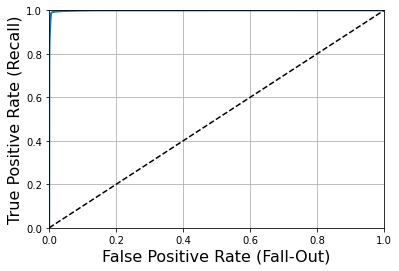

AUC score:  0.9990367618817099


In [83]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=30, max_depth = 10, random_state=23)
forest_clf.fit(train_new, np.ravel(outcome_train_new[:,5]))
performance_DecisionTree(5, train_new, outcome_train_new, forest_clf)

Decision Tree J48 accuracy:  0.9802107703204481
Confusion matrix: 
 [[61895   807]
 [ 1037 29443]]
Precision:  0.9733223140495868
Recall:  0.9659776902887139
F score:  0.9696360941873868


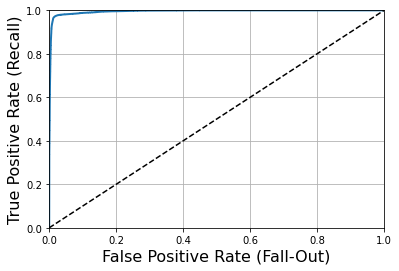

AUC score:  0.9950221155566417


In [84]:
forest_clf = RandomForestClassifier(n_estimators=30, max_depth = 10, random_state=23)
forest_clf.fit(train_new, np.ravel(outcome_train_new[:,5]))
performance_DecisionTree_testdata(4, test_new, outcome_test_new, forest_clf)

Decision Tree J48 accuracy:  0.7850390243902439
Confusion matrix: 
 [[131335  37135]
 [  6932  29598]]
Precision:  0.44352868895449027
Recall:  0.8102381604160963
F score:  0.5732546991662067


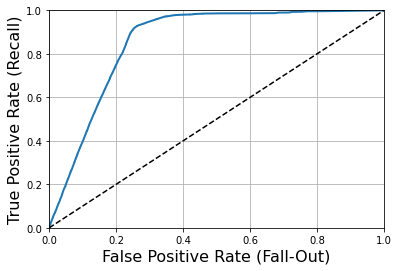

AUC score:  0.8578855135910153


In [85]:
forest_clf = RandomForestClassifier(n_estimators=30, max_depth = 10, random_state=23)
forest_clf.fit(train_new_30, np.ravel(outcome_train_new_30[:,5]))
performance_DecisionTree_testdata(4, test_new_30, outcome_test_new_30, forest_clf)

Decision Tree J48 accuracy:  0.7289034363686292
Confusion matrix: 
 [[201158  72254]
 [ 13634  29771]]
Precision:  0.2918010291595197
Recall:  0.6858887224974082
F score:  0.40942033968232144


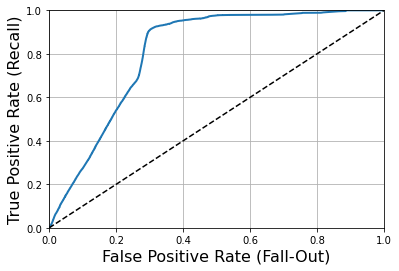

AUC score:  0.8073846235124726


In [86]:
forest_clf = RandomForestClassifier(n_estimators=30, max_depth = 10, random_state=23)
forest_clf.fit(train_new_60, np.ravel(outcome_train_new_60[:,5]))
performance_DecisionTree_testdata(4, test_new_60, outcome_test_new_60, forest_clf)

In [87]:
from sklearn.linear_model import Perceptron
per_clf = Perceptron(random_state=23)
per_clf.fit(train_top6best, np.ravel(outcome_train_new[:,5]))

result_Perceptron = cross_val_score(per_clf, train_top6best, np.ravel(outcome_train_new[:,5]), cv=10, scoring="accuracy")

print('Perceptron accuracy: ', result_Perceptron)

out_Perceptron_pred = cross_val_predict(per_clf, train_top6best, np.ravel(outcome_train_new[:,5]), cv=10)

print('Confusion matrix: \n', confusion_matrix(np.ravel(outcome_train_new[:,5]), out_Perceptron_pred))
print('Precision: ', precision_score(np.ravel(outcome_train_new[:,5]), out_Perceptron_pred))
print('Recall: ', recall_score(np.ravel(outcome_train_new[:,5]), out_Perceptron_pred))
print('F score: ', f1_score(np.ravel(outcome_train_new[:,5]), out_Perceptron_pred))

Perceptron accuracy:  [0.81388673 0.77275776 0.81525501 0.79239664 0.76715048 0.58376261
 0.7482024  0.8229502  0.80336446 0.73905344]
Confusion matrix: 
 [[209191  47388]
 [ 39875  76271]]
Precision:  0.616784868064597
Recall:  0.6566821070032546
F score:  0.6361085048268385


In [88]:
result_Perceptron = per_clf.score(test_top6best, np.ravel(outcome_test_new[:,4]))
    
print('Perceptron accuracy: ', result_Perceptron)

out_Perceptron_pred = per_clf.predict(test_top6best)

print('Confusion matrix: \n', confusion_matrix(np.ravel(outcome_test_new[:,4]), out_Perceptron_pred))
print('Precision: ', precision_score(np.ravel(outcome_test_new[:,4]), out_Perceptron_pred))
print('Recall: ', recall_score(np.ravel(outcome_test_new[:,4]), out_Perceptron_pred))
print('F score: ', f1_score(np.ravel(outcome_test_new[:,4]), out_Perceptron_pred))

Perceptron accuracy:  0.682202571312056
Confusion matrix: 
 [[60855  1847]
 [27766  2714]]
Precision:  0.5950449462837097
Recall:  0.08904199475065616
F score:  0.1549042550155532


In [89]:
train_new = train_new.astype('float64')
test_new = test_new.astype('float64')
outcome_train_new = outcome_train_new.astype('float64')
outcome_test_new = outcome_test_new.astype('float64')

In [90]:
train_top10best = train_top10best.astype('float64')
train_top6best = train_top6best.astype('float64')
train_top3best = train_top3best.astype('float64')
test_top10best = test_top10best.astype('float64')
test_top6best = test_top6best.astype('float64')
test_top3best = test_top3best.astype('float64')

In [91]:
gc.collect()
model_1 = keras.models.Sequential([
    keras.layers.Input(shape=train_top6best.shape[1]),
    keras.layers.Dense(60, activation="tanh"),
    keras.layers.Dense(60, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])
model_1.summary()
model_1.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics="binary_accuracy")
history = model_1.fit(train_top6best, np.ravel(outcome_train_new[:,5]), batch_size=128, epochs=3, validation_split=0.1,shuffle=False,)

mse_test = model_1.evaluate(test_top6best, np.ravel(outcome_test_new[:,4]))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 60)                420       
_________________________________________________________________
dense_1 (Dense)              (None, 60)                3660      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 61        
Total params: 4,141
Trainable params: 4,141
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
2621/2621 [==============================] - 8s 2ms/step - loss: 0.0434 - binary_accuracy: 0.9834 - val_loss: 0.0342 - val_binary_accuracy: 0.9890
Epoch 2/3
2621/2621 [==============================] - 5s 2ms/step - loss: 0.0307 - binary_accuracy: 0.9882 - val_loss: 0.0421 - val_binary_accuracy: 0.9864
Epoch 3/3
2912/2912 [==============================] - 3s 1ms/step - l

In [92]:
gc.collect()
model_1 = keras.models.Sequential([
    keras.layers.Input(shape=train_top6best.shape[1]),
    keras.layers.Dense(60, activation="tanh"),
    keras.layers.Dense(60, activation="selu"),
    keras.layers.Dense(50, activation="sigmoid")
])
model_1.summary()
model_1.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics="accuracy")
history = model_1.fit(train_top6best, outcome_train_new, batch_size=128, epochs=3, validation_split=0.1,shuffle=False,)

mse_test = model_1.evaluate(test_top6best, outcome_test_new)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 60)                420       
_________________________________________________________________
dense_4 (Dense)              (None, 60)                3660      
_________________________________________________________________
dense_5 (Dense)              (None, 50)                3050      
Total params: 7,130
Trainable params: 7,130
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
2621/2621 [==============================] - 7s 2ms/step - loss: 0.4460 - accuracy: 0.8505 - val_loss: 0.3919 - val_accuracy: 0.8623
Epoch 2/3
2621/2621 [==============================] - 5s 2ms/step - loss: 0.3427 - accuracy: 0.8866 - val_loss: 0.3369 - val_accuracy: 0.8633
Epoch 3/3
2912/2912 [==============================] - 3s 1ms/step - loss: 10.4337 - accuracy: 0

In [93]:
y_train = train_new0.iloc[:,3]
y_test = test_new0.iloc[:,3]
y_train = y_train.astype('float64')
y_test = y_test.astype('float64')

In [94]:
gc.collect()
model_1 = keras.models.Sequential([
    keras.layers.Input(shape=train_top6best.shape[1]),
    keras.layers.Dense(40, activation="relu"),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(20, activation="sigmoid"),
    keras.layers.Dense(1)
])
model_1.summary()
model_1.compile(loss="mean_absolute_error", optimizer=keras.optimizers.RMSprop(learning_rate=0.0001), metrics=['mean_absolute_error'])
history = model_1.fit(train_top6best, y_train, batch_size=200, epochs=6, validation_split=0.1,shuffle=False,)

mse_test = model_1.evaluate(test_top6best, y_test)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 40)                280       
_________________________________________________________________
dense_7 (Dense)              (None, 30)                1230      
_________________________________________________________________
dense_8 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 21        
Total params: 2,151
Trainable params: 2,151
Non-trainable params: 0
_________________________________________________________________
Epoch 1/6
1678/1678 [==============================] - 4s 2ms/step - loss: 17.9362 - mean_absolute_error: 17.9362 - val_loss: 15.8906 - val_mean_absolute_error: 15.8906
Epoch 2/6
1678/1678 [==============================] - 3s 2ms/step - loss: 16.647

In [95]:
class MLP():
    def __init__(self, number_of_layers, number_of_neurons, activation_functions, learning_rate, loss_function):
        self.number_of_layers = number_of_layers
        self.number_of_neurons = number_of_neurons
        self.activation_functions = activation_functions
        self.learning_rate = learning_rate
        self.loss_function = loss_function

    def fit_and_transform(self, data_original, test_data, outcome, epochs):
        self.data_original = data_original
        self.outcome = outcome
        self.epochs = epochs
        self.weights = [1]*self.number_of_layers
        self.biases = [1]*self.number_of_layers

        # initialize input layer weights and biases with random number [0,1)
        self.weights[0] = np.random.rand(self.number_of_neurons[0], data_original.shape[1])
        self.biases[0] = np.random.rand(self.number_of_neurons[0], 1)
        for i in range(self.number_of_layers):
            if i == 0:
                continue
            else:
                # initialize hidden layer and output layer
                self.weights[i] = np.random.rand(self.number_of_neurons[i], self.number_of_neurons[i - 1])
                self.biases[i] = np.random.rand(self.number_of_neurons[i], 1)

        # initialize z value array size
        z = [1]*self.number_of_layers
        # initialize a value array size
        a = [1]*self.number_of_layers

        # the number of epochs
        for j in range(self.epochs):
            # we use mini-batch learning here, a batch size is 128
            for k in range(0,data_original.shape[0]-128,128):
                # initialize temp variable value with input data
                value = (data_original.iloc[k:k+128,:]).T
                # forward
                for i in range(self.number_of_layers):
                    # get z value by using weights dot product a, and plus bias
                    z[i] = np.dot(self.weights[i], value) + self.biases[i]
                    # apply different activation functions
                    if self.activation_functions[i] == 'sigmoid':
                        value = self.sigmoid(z[i])
                    elif self.activation_functions[i] == 'tanh':
                        value = self.tanh(z[i])
                    elif self.activation_functions[i] == 'ReLU':
                        value = self.ReLU(z[i])
                    elif self.activation_functions[i] == 'Leaky_ReLU':
                        value = self.Leaky_ReLU(z[i])
                    # store a value
                    a[i] = value

                # back-propagation
                # initialize delta of biases and weights array size
                delta_bias = [1] * self.number_of_layers
                delta_weights = [1] * self.number_of_layers
                # calculate output layer first
                if self.loss_function == 'MSE':
                    # different loss function will have different way to calculate delta value of final layer
                    loss = a[-1] - self.outcome[k:k+128]
                    delta_final = np.array(loss) * np.array(self.dsigmoid(z[-1]))
                    delta_bias[-1] = delta_final
                    # if there are more than one layer
                    if len(a) != 1:
                        delta_weights[-1] = np.dot(delta_final, a[-2].T)
                    else:
                        # if only one layer
                        delta_weights[-1] = np.dot(delta_final, self.data_original.iloc[k:k+128,:])
                elif self.loss_function == 'cross_entropy':
                    loss = a[-1] - self.outcome[k:k+128]
                    delta_final = loss
                    delta_bias[-1] = delta_final
                    if len(a) != 1:
                        delta_weights[-1] = np.dot(delta_final, a[-2].T)
                    else:
                        delta_weights[-1] = np.dot(delta_final, self.data_original.iloc[k:k+128,:])

                delta = delta_final
                # calculate other layers' delta value
                for i in range(1, self.number_of_layers):
                    if self.activation_functions[~i] == 'sigmoid':
                        delta = np.array(np.dot(self.weights[~i + 1].T, delta)) * np.array(self.dsigmoid(z[~i]))
                    elif self.activation_functions[~i] == 'tanh':
                        delta = np.array(np.dot(self.weights[~i + 1].T, delta)) * np.array(self.dtanh(z[~i]))
                    elif self.activation_functions[~i] == 'ReLU':
                        delta = np.array(np.dot(self.weights[~i + 1].T, delta)) * np.array(self.dReLU(z[~i]))
                    elif self.activation_functions[~i] == 'Leaky_ReLU':
                        delta = np.array(np.dot(self.weights[~i + 1].T, delta)) * np.array(self.dLeaky_ReLU(z[~i]))
                    # delta of bias is the delta value
                    delta_bias[~i] = delta
                    # delta of weights have to dot product a value
                    if i != self.number_of_layers - 1:
                        delta_weights[~i] = np.dot(delta, a[~i - 1].T)
                    else:
                        delta_weights[~i] = np.dot(delta, self.data_original.iloc[k:k+128,:])
                # finally update weights and biases, remember to divide total delta by 128 which is batch size
                for i in range(self.number_of_layers):
                    self.weights[i] = self.weights[i] - self.learning_rate * delta_weights[i] / 128
                    self.biases[i] = self.biases[i] - self.learning_rate * (np.dot(delta_bias[i],np.matrix(np.ones(128)).T))/128
                # start next epoch

        result = []
        # using the same batch size as train, do forward again
        for k in range(0,test_data.shape[0]-128,128):
            value = test_data.iloc[k:k+128,:].T
            for i in range(self.number_of_layers):

                z[i] = np.dot(self.weights[i], value) + self.biases[i]

                if self.activation_functions[i] == 'sigmoid':
                    value = self.sigmoid(z[i])
                elif self.activation_functions[i] == 'tanh':
                    value = self.tanh(z[i])
                elif self.activation_functions[i] == 'ReLU':
                    value = self.ReLU(z[i])
                elif self.activation_functions[i] == 'Leaky_ReLU':
                    value = self.Leaky_ReLU(z[i])

                a[i] = value

            result = np.vstack((np.array(result).reshape(-1,1),(np.array(a[-1].T))))


        return result

    def sigmoid(self, z):
        z = np.clip(z, -500, 500)
        return 1.0 / (1.0 + np.exp(-z))

    def tanh(self, z):
        return np.tanh(z)

    def ReLU(self, z):
        return np.maximum(z, 0)

    def Leaky_ReLU(self, z):
        alpha = 0.01
        return np.maximum(z, z * alpha)

    def dsigmoid(self, z):
        return np.array(1.0 / (1.0 + np.exp(-z))) * np.array(1 - 1.0 / (1.0 + np.exp(-z)))

    def dtanh(self, z):
        return 1 - np.array(np.tanh(z)) * np.array(np.tanh(z))

    def dReLU(self, z):
        z[z >= 0] = 1
        z[z < 0] = 0
        return z

    def dLeaky_ReLU(self, z):
        z[z >= 0] = 1
        z[z < 0] = 0.01
        return z

In [96]:
myMLP = MLP(3, [50, 50, 1], ['tanh', 'Leaky_ReLU','sigmoid'], 0.01, 'cross_entropy')
result = np.array(myMLP.fit_and_transform(train_top6best, test_top6best, np.ravel(outcome_train_new[:,5]), 10))

f = pd.concat([pd.DataFrame(result), pd.DataFrame(np.ravel(outcome_test_new[:,4]))], axis=1)
f.columns = ['result', 'Outcome']
f['pred'] = f['result'].apply(lambda x: 0 if x < 0.5 else 1)
accuracy = (f.loc[f['pred'] == f['Outcome']].shape[0] / f.shape[0] * 100)
print("Accuracy (Loss minimization):")
print(accuracy)

Accuracy (Loss minimization):
97.66800455023503


In [97]:
def sigmoid(z):
    z = np.clip(z, -500, 500)
    return 1.0 / (1.0 + np.exp(-z))


def tanh(z):
    return np.tanh(z)


def ReLU(z):
    return np.maximum(z, 0)


def Leaky_ReLU(z):
    alpha = 0.01
    return np.maximum(z, z * alpha)


class MLP_PSO():
    def __init__(self, number_of_layers, number_of_neurons, activation_functions, loss_function):
        self.number_of_layers = number_of_layers
        self.number_of_neurons = number_of_neurons
        self.activation_functions = activation_functions
        self.loss_function = loss_function

    def fit_and_transform(self, X_train, X_test, y_train, y_test, epochs, swarm_size, number_of_informants, alpha, beta,
                          gamma, delta, epsilon):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.epochs = epochs
        self.swarm_size = swarm_size
        self.number_of_informants = number_of_informants
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.epsilon = epsilon
        self.delta = delta
        self.position = [0] * self.swarm_size
        self.velocity = [0] * self.swarm_size
        self.pbest = [0] * self.swarm_size
        self.ibest = [0] * self.swarm_size
        self.gbest = [0]
        self.informants = [0] * self.swarm_size

        temp_max = -0x3F3F3F3F
        temp = np.zeros(self.swarm_size)
        for j in range(self.swarm_size):
            # calculate dimensions
            swarm_dimension = self.number_of_neurons[0] * self.X_train.shape[1] + self.number_of_neurons[0]
            for i in range(self.number_of_layers):
                if i == 0:
                    continue
                else:
                    swarm_dimension += self.number_of_neurons[i] * self.number_of_neurons[i - 1] + \
                                       self.number_of_neurons[i]

            # [0,1)
            self.position[j] = np.random.rand(1, swarm_dimension)

            for a in self.activation_functions:
                self.position[j] = np.append(self.position[j], a)

            self.velocity[j] = np.random.rand(1, swarm_dimension + self.number_of_layers)
            self.pbest[j] = self.position[j]
            temp_list = list(range(swarm_size))
            temp_list.remove(j)
            np.random.shuffle(temp_list)
            self.informants[j] = np.array(temp_list[:number_of_informants - 1])
            self.informants[j] = np.append(self.informants[j], j)
            temp[j] = self.update_fitness(X_train, y_train, self.position[j])
            if temp_max < temp[j]:
                temp_max = temp[j]
                self.gbest = self.position[j]

        for i in range(self.swarm_size):
            temp_max = -0x3F3F3F3F
            for j in range(self.number_of_informants):
                if temp_max < temp[self.informants[i][j]]:
                    temp_max = temp[self.informants[i][j]]
                    self.ibest[i] = self.position[self.informants[i][j]]

        # the number of epochs
        for t in range(self.epochs):
            temp_max = self.update_fitness(X_train, y_train, self.gbest)
            for i in range(self.swarm_size):
                self.velocity[i] = self.alpha * self.velocity[i] \
                                   + np.random.rand() * self.beta * (self.pbest[i] - self.position[i]) \
                                   + np.random.rand() * self.gamma * (self.ibest[i] - self.position[i]) \
                                   + np.random.rand() * self.delta * (self.gbest - self.position[i])
                self.position[i] = self.position[i] + self.epsilon * self.velocity[i]
                # boundary of activation functions
                for a in range(swarm_dimension + self.number_of_layers - 1, swarm_dimension - 1, -1):
                    if self.position[i][0, a] > 4.5:
                        self.position[i][0, a] = 4.5
                    elif self.position[i][0, a] < 0.5:
                        self.position[i][0, a] = 0.5

                temp[i] = self.update_fitness(X_train, y_train, self.position[i])
                if self.update_fitness(X_train, y_train, self.pbest[i]) < temp[i]:
                    self.pbest[i] = self.position[i]

                if temp_max < temp[i]:
                    temp_max = temp[i]
                    self.gbest = self.position[i]

            for i in range(self.swarm_size):
                temp_max = -0x3F3F3F3F
                for j in range(self.number_of_informants):
                    if temp_max < temp[self.informants[i][j]]:
                        temp_max = temp[self.informants[i][j]]
                        self.ibest[i] = self.position[self.informants[i][j]]

        return self.update_fitness(X_test, y_test, self.gbest) * 100 / (X_test.shape[0] // 128)

    def update_fitness(self, X_data, y_data, position):
        weights = [1] * self.number_of_layers
        biases = [1] * self.number_of_layers
        activation_functions = [1] * self.number_of_layers
        self.deserialization(position, weights, biases, activation_functions)
        result = 0

        
        value = (X_data).T
        for i in range(self.number_of_layers):
            z = np.dot(weights[i], value) + biases[i]
            if activation_functions[i] == 'sigmoid':
                value = sigmoid(z)
            elif activation_functions[i] == 'tanh':
                value = tanh(z)
            elif activation_functions[i] == 'ReLU':
                value = ReLU(z)
            elif activation_functions[i] == 'Leaky_ReLU':
                value = Leaky_ReLU(z)
            a = value

            a = a.reshape(-1, 1)
            a = np.where(a >= 0.5, 1, 0)
            result = np.sum(a == y_data.reshape(-1, 1)) 

        return result

    def deserialization(self, position, weights, biases, activation_functions):
        index = 0
        position = position.reshape(1, -1)
        for i in range(self.number_of_layers):
            temp = [0] * self.number_of_neurons[i]
            temp = np.array(temp).reshape(-1, 1)
            if i == 0:
                for j in range(self.X_train.shape[1]):
                    temp = np.hstack((temp, position[0, index:index + self.number_of_neurons[i]].reshape(-1, 1)))
                    index = index + self.number_of_neurons[i]
            else:
                for j in range(self.number_of_neurons[i - 1]):
                    temp = np.hstack((temp, position[0, index:index + self.number_of_neurons[i]].reshape(-1, 1)))
                    index = index + self.number_of_neurons[i]

            temp = np.delete(temp, 0, axis=1)
            weights[i] = temp
            biases[i] = position[0, index:index + self.number_of_neurons[i]].reshape(-1, 1)
            index = index + self.number_of_neurons[i]

        for i in range(self.number_of_layers):
            if 0.5 <= position[0, index] < 1.5:
                activation_functions[i] = 'sigmoid'
            elif 1.5 <= position[0, index] < 2.5:
                activation_functions[i] = 'tanh'
            elif 2.5 <= position[0, index] < 3.5:
                activation_functions[i] = 'ReLU'
            elif 3.5 <= position[0, index] <= 4.5:
                activation_functions[i] = 'Leaky_ReLU'
            index = index + 1

In [98]:
# myMLP_PSO = MLP_PSO(2, [30, 1], [2, 1], 'cross_entropy')
# print(myMLP_PSO.fit_and_transform(train_new, test_new, np.ravel(outcome_train_new[:,5]), np.ravel(outcome_test_new[:,4]), 30, 100, 10, 0.9, 1.5, 1.5, 1, 0.1))

In [99]:
# myMLP_PSO = MLP_PSO(2, [30, 1], [2, 1], 'MSE')
# print(myMLP_PSO.fit_and_transform(train_new, test_new, np.array(y_train), np.array(y_test), 30, 100, 10, 0.9, 1.5, 1.5, 1, 0.1))

In [100]:
cluster1 = np.random.rand(10,2)
cluster1

array([[0.78268512, 0.80765589],
       [0.4349354 , 0.75712895],
       [0.53271804, 0.03085108],
       [0.98009581, 0.54195936],
       [0.74694578, 0.71008745],
       [0.54057133, 0.93209914],
       [0.43691254, 0.00259448],
       [0.37909258, 0.85263732],
       [0.31476589, 0.4246626 ],
       [0.36240183, 0.44468325]])

In [101]:
cluster2 = np.random.rand(20,2)
cluster2

array([[0.59042708, 0.89856315],
       [0.04927266, 0.95073934],
       [0.07403978, 0.71594502],
       [0.69660396, 0.30587574],
       [0.72779335, 0.36125113],
       [0.00589726, 0.02561578],
       [0.77470575, 0.50895483],
       [0.92409088, 0.12906421],
       [0.07994786, 0.02798974],
       [0.40670672, 0.18594343],
       [0.91036039, 0.63875552],
       [0.65796895, 0.79714722],
       [0.07676714, 0.35670933],
       [0.99802663, 0.48795247],
       [0.20379528, 0.41429932],
       [0.7503896 , 0.1453506 ],
       [0.34166673, 0.3570216 ],
       [0.20698282, 0.89721957],
       [0.40923253, 0.38154219],
       [0.53866721, 0.7513874 ]])

In [102]:
intra_cluster_distance = 0
nearest_cluster_distance = 0
import time
start_time = time.time()
for i in range(9):
    intra_cluster_distance = intra_cluster_distance + ((cluster1[0,0]-cluster1[i+1,0]) ** 2 + (cluster1[0,1]-cluster1[i+1,1]) ** 2) ** 0.5

intra_cluster_distance = intra_cluster_distance / 9
t1 = time.time() - start_time
for i in range(19):
    nearest_cluster_distance = nearest_cluster_distance + ((cluster1[0,0]-cluster2[i+1,0]) ** 2 + (cluster1[0,1]-cluster2[i+1,1]) ** 2) ** 0.5

nearest_cluster_distance = nearest_cluster_distance / 9

In [103]:
t1

0.0005002021789550781

In [104]:
intra_cluster_distance

0.47964885448956807

In [105]:
nearest_cluster_distance

1.249363157242858

In [106]:
(nearest_cluster_distance - intra_cluster_distance)/nearest_cluster_distance

0.616085321782599

In [107]:
start_time = time.time()
intra_cluster_distance = np.linalg.norm(cluster1[1:,:]-cluster1[0,:], ord = 2, axis = 1)
t1 = time.time() - start_time
t1

0.0005006790161132812

In [108]:
intra_cluster_distance

array([0.35140125, 0.81603264, 0.33100699, 0.10390814, 0.27222273,
       0.87617495, 0.40609146, 0.60467534, 0.55532619])

In [109]:
intra_cluster_distance = sum(intra_cluster_distance) / 9

In [110]:
intra_cluster_distance

0.47964885448956807

In [111]:
nearest_cluster_distance = np.linalg.norm(cluster2[1:,:]-cluster1[0,:], ord = 2, axis = 1)

In [112]:
nearest_cluster_distance

array([0.74723939, 0.71455518, 0.50911029, 0.44976696, 1.10226409,
       0.29880762, 0.69316827, 1.04962801, 0.72655773, 0.21172697,
       0.12515812, 0.83765924, 0.38546367, 0.69988774, 0.66309222,
       0.63053032, 0.5826275 , 0.56660368, 0.25042142])

In [113]:
nearest_cluster_distance = sum(nearest_cluster_distance) / 9

In [114]:
nearest_cluster_distance

1.249363157242858

In [115]:
(nearest_cluster_distance - intra_cluster_distance)/nearest_cluster_distance

0.616085321782599